<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.983 · Aprenentatge per reforç</p>
<p style="margin: 0; text-align:right;">2024-1 · Màster universitari en Ciència de dades (<i>Data science</i>)</p>
<p style="margin: 0; text-align:right; padding-bottom: 100px;">Estudis d'Informàtica, Multimèdia i Telecomunicació</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>

# PEC3: Deep Reinforcement Learning (II)

L'objectiu d'aquesta pràctica és utilitzar la llibreria [stable baselines 3](https://stable-baselines3.readthedocs.io/en/master/), que ja te implementats algoritmes d'aprenentatge per reforç, per solucionar una versió modificada del cartpole, anomenada cartpole target. Els objectius d'aquesta pràctica són:
<ol>
    <li>Desenvolupar una capacitat analítica sobre com està funcionant el model.</li>
    <li>Familiaritzar-se amb la llibreria stable baselines 3.</li>
    <li>Analitzar l'efecte de modificar la funció de recompensa durant l'entrenament de l'agent.</li>
    <li>Analitzar l'efecte de modificar l'espai d'accions.</li>
    <li>Ser capaços de realitzar una cerca d'hiperparàmetres.</li>
    <li>(Opcional) Familiaritzar-se amb l'anàlisi mitjançant tensorboard.</li>
</ol>

**Important: El lliurament s'ha de fer en format notebook i en format html on es vegi el codi i els resultats i comentaris de cada exercici. Per exportar el notebook a html es pot fer des del menú File → Download as → HTML.**


# 0. Cartpole target (2 punts)

En aquesta pràctica utilitzarem un entorn anomenat cartpole random target. Aquest entorn està fora de la llibreria gymnasium i és una modificació de l'entorn [cartpole](https://gymnasium.farama.org/environments/classic_control/cart_pole/). En aquest entorn, l'objectiu no només és mantenir el pal estable, sinó que el carro ha d'estar el més a prop possible d'un punt objectiu, el qual es pot observar marcat en verd quan es renderitza l'entorn:

![image-1.png](image.png)

Hi ha alguns paràmetres en l'entorn que permeten regular com de rellevant volem que sigui el punt objectiu, fins al punt que podem aconseguir que aquesta modificació es comporti com el cartpole original.


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
    <strong>Exercici 0.1 (0.75 punts):</strong> Llegeix el codi de l'entorn que es proporciona a continuació detingudament. Ignoreu tots els TODOS, són coses que haurem d'implementar a mesura que la pràctica avanci. Després, responeu les següents preguntes:
    <ul>
      <li>Quin és l'espai d'observacions? Com es distingeix respecte a la versió bàsica de cartpole?</li>
      <li>Quines dues versions de la reward existeixen en l'entorn?</li>
      <li>Per al cas en que la reward és custom, què fa el paràmetre target_desire_factor?</li>
    </ul>
</div>


In [1]:
"""
Classic cart-pole system implemented by Rich Sutton et al.
Copied from http://incompleteideas.net/sutton/book/code/pole.c
permalink: https://perma.cc/C9ZM-652R
"""

import math
from typing import Optional, Union

import numpy as np

import gymnasium as gym
from gymnasium import spaces
from gymnasium.envs.classic_control import utils
from gymnasium.error import DependencyNotInstalled



class CartPoleEnvRandomTarget(gym.Env[np.ndarray, Union[int, np.ndarray]]):
    """
    ## Description

    This environment corresponds to a modification of the version of the cart-pole problem described by Barto, Sutton, and Anderson in
    ["Neuronlike Adaptive Elements That Can Solve Difficult Learning Control Problem"](https://ieeexplore.ieee.org/document/6313077).
    A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track.
    The pendulum is placed upright on the cart and the goal is to balance the pole by applying forces
     in the left and right direction on the cart.
     The modification consists on a target appearing into scene. The cart must be as close to the target as posible

    For more details about original cartpole look for source code in gymnasium.
    """


    metadata = {
        "render_modes": ["human", "rgb_array"],
        "render_fps": 50,
    }

    def __init__(
        self,
        target_desire_factor: float = 0.5,
        reward_function: str = "default",
        is_eval=False,
        increased_actions=False,
        render_mode: Optional[str] = None,
    ):

        self.gravity = 9.8
        self.masscart = 1.0
        self.masspole = 0.1
        self.total_mass = self.masspole + self.masscart
        self.length = 0.5  # actually half the pole's length
        self.polemass_length = self.masspole * self.length
        self.force_mag = 10.0
        self.tau = 0.02  # seconds between state updates

        self.max_steps = 500
        self.steps = 0

        # Angle at which to fail the episode
        self.theta_threshold_radians = 12 * 2 * math.pi / 360
        self.x_threshold = 2.4
        self.target_threshold = 2

        high = np.array(
            [
                self.x_threshold * 2,
                np.inf,
                self.theta_threshold_radians * 2,
                np.inf,
                self.target_threshold * 2,
            ],
            dtype=np.float32,
        )
        self.increased_actions = increased_actions
        if self.increased_actions:
            #TODO 3.1: Ampliar l'espai d'observacions
            raise NotImplementedError("Increased actions should be implemented")
        else:
            self.action_space = spaces.Discrete(2)
        self.observation_space = spaces.Box(-high, high, dtype=np.float32)

        self.render_mode = render_mode

        self.screen_width = 600
        self.screen_height = 400
        self.screen = None
        self.clock = None
        self.isopen = True
        self.state: np.ndarray | None = None

        self.steps_beyond_terminated = None

        #TODO 1.3: Tenir en compte si l'entorn és d'avaluació
        self.is_eval = is_eval
        self.target_position = self.generate_random_target_position()

        self.target_desire_factor = min(
            max(target_desire_factor, 0), 1
        )  # between 0 and 1
        if reward_function in ["default", "custom"]:
            self.reward_function = reward_function
        else:
            raise AttributeError("reward function must be either default or custom")

    def generate_random_target_position(
        self,
    ):
        if self.is_eval:
            #TODO 1.3:Tingueu en compte si l'entorn és d'avaluació per situar el target en unes posicions concretes.
            raise NotImplementedError("You should implement is_eval casuistic")
            return target_position
        else:
            return np.random.uniform(-self.x_threshold, self.x_threshold)

    def custom_reward(self, target_position, current_position, angle, terminated):
        if self.reward_function == "default":
            #Reward default del cartpole
            return 1 if not terminated else 0
        else:
            angle_reward = (
                -abs(angle) / (2.0 * self.x_threshold) / self.theta_threshold_radians
            )
            target_reward = -(abs(target_position - current_position) ** 2) / (
                (2 * self.x_threshold) ** 2
            )
            return (
                1
                + self.target_desire_factor * target_reward
                + (1 - self.target_desire_factor) * angle_reward
            )
        #TODO 2.2: Implementar 2 funcions de reward extra

    def step(self, action):
        assert self.action_space.contains(
            action
        ), f"{action!r} ({type(action)}) invalid"
        assert self.state is not None, "Call reset before using step method."
        x, x_dot, theta, theta_dot, _ = self.state
        if self.increased_actions:
            force_factor = action - 3
            force = (
                force_factor / 3 * self.force_mag
                if force_factor > 0
                else (force_factor - 1) / 3 * self.force_mag
            )
        else:
            force = self.force_mag if action == 1 else -self.force_mag
        costheta = np.cos(theta)
        sintheta = np.sin(theta)

        # For the interested reader:
        # https://coneural.org/florian/papers/05_cart_pole.pdf
        temp = (
            force + self.polemass_length * np.square(theta_dot) * sintheta
        ) / self.total_mass
        thetaacc = (self.gravity * sintheta - costheta * temp) / (
            self.length
            * (4.0 / 3.0 - self.masspole * np.square(costheta) / self.total_mass)
        )
        xacc = temp - self.polemass_length * thetaacc * costheta / self.total_mass

        x = x + self.tau * x_dot
        x_dot = x_dot + self.tau * xacc
        theta = theta + self.tau * theta_dot
        theta_dot = theta_dot + self.tau * thetaacc

        self.state = np.array(
            (x, x_dot, theta, theta_dot, self.target_position), dtype=np.float64
        ) #Aquest estat es diferent respecte al del cartpole original

        terminated = bool(
            x < -self.x_threshold
            or x > self.x_threshold
            or theta < -self.theta_threshold_radians
            or theta > self.theta_threshold_radians
        )

        reward = self.custom_reward(self.target_position, x, theta, terminated)

        if self.render_mode == "human":
            self.render()

        # truncation=False as the time limit is handled by the `TimeLimit` wrapper added during `make`
        self.steps += 1
        if self.steps >= self.max_steps:
            truncated = True
        else:
            truncated = False
        return np.array(self.state, dtype=np.float32), reward, terminated, truncated, {}

    def reset(
        self,
        *,
        seed: Optional[int] = None,
        options: Optional[dict] = None,
    ):

        super().reset(seed=seed)
        self.steps = 0
        # Note that if you use custom reset bounds, it may lead to out-of-bound
        # state/observations.
        low, high = utils.maybe_parse_reset_bounds(
            options, -0.05, 0.05  # default low
        )  # default high

        self.state = self.np_random.uniform(low=low, high=high, size=(4,)).tolist()
        self.steps_beyond_terminated = None

        #Generar posició aleatòria del target i guardar en l'estat
        self.target_position = self.generate_random_target_position()
        self.state.append(self.target_position)

        self.state = np.array(self.state)
        if self.render_mode == "human":
            self.render()
        return np.array(self.state, dtype=np.float32), {}

    def render(self):
        if self.render_mode is None:
            assert self.spec is not None
            gym.logger.warn(
                "You are calling render method without specifying any render mode. "
                "You can specify the render_mode at initialization, "
                f'e.g. gym.make("{self.spec.id}", render_mode="rgb_array")'
            )
            return

        try:
            import pygame
            from pygame import gfxdraw
        except ImportError as e:
            raise DependencyNotInstalled(
                'pygame is not installed, run `pip install "gymnasium[classic-control]"`'
            ) from e

        if self.screen is None:
            pygame.init()
            if self.render_mode == "human":
                pygame.display.init()
                self.screen = pygame.display.set_mode(
                    (self.screen_width, self.screen_height)
                )
            else:  # mode == "rgb_array"
                self.screen = pygame.Surface((self.screen_width, self.screen_height))
        if self.clock is None:
            self.clock = pygame.time.Clock()

        world_width = self.x_threshold * 2
        scale = self.screen_width / world_width
        polewidth = 10.0
        polelen = scale * (2 * self.length)
        cartwidth = 50.0
        cartheight = 30.0
        targetwidth = 10
        targetheight = 10

        if self.state is None:
            return None

        x = self.state

        self.surf = pygame.Surface((self.screen_width, self.screen_height))
        self.surf.fill((255, 255, 255))

        l, r, t, b = -cartwidth / 2, cartwidth / 2, cartheight / 2, -cartheight / 2
        axleoffset = cartheight / 4.0
        cartx = x[0] * scale + self.screen_width / 2.0  # MIDDLE OF CART
        carty = 100  # TOP OF CART
        cart_coords = [(l, b), (l, t), (r, t), (r, b)]
        cart_coords = [(c[0] + cartx, c[1] + carty) for c in cart_coords]
        gfxdraw.aapolygon(self.surf, cart_coords, (0, 0, 0))
        gfxdraw.filled_polygon(self.surf, cart_coords, (0, 0, 0))

        l, r, t, b = (
            -polewidth / 2,
            polewidth / 2,
            polelen - polewidth / 2,
            -polewidth / 2,
        )

        pole_coords = []
        for coord in [(l, b), (l, t), (r, t), (r, b)]:
            coord = pygame.math.Vector2(coord).rotate_rad(-x[2])
            coord = (coord[0] + cartx, coord[1] + carty + axleoffset)
            pole_coords.append(coord)
        gfxdraw.aapolygon(self.surf, pole_coords, (202, 152, 101))
        gfxdraw.filled_polygon(self.surf, pole_coords, (202, 152, 101))

        gfxdraw.aacircle(
            self.surf,
            int(cartx),
            int(carty + axleoffset),
            int(polewidth / 2),
            (129, 132, 203),
        )
        gfxdraw.filled_circle(
            self.surf,
            int(cartx),
            int(carty + axleoffset),
            int(polewidth / 2),
            (129, 132, 203),
        )

        l, r, t, b = (
            -targetwidth / 2,
            targetwidth / 2,
            targetheight / 2,
            -targetheight / 2,
        )
        axleoffset = targetheight / 4.0
        targetx = x[-1] * scale + self.screen_width / 2.0  # MIDDLE OF target
        targety = 90  # TOP OF target
        target_coords = [(l, b), (l, t), (r, t), (r, b)]
        target_coords = [(c[0] + targetx, c[1] + targety) for c in target_coords]
        gfxdraw.aapolygon(self.surf, target_coords, (10, 255, 10))
        gfxdraw.filled_polygon(self.surf, target_coords, (10, 255, 10))

        gfxdraw.hline(self.surf, 0, self.screen_width, carty, (0, 0, 0))

        self.surf = pygame.transform.flip(self.surf, False, True)
        self.screen.blit(self.surf, (0, 0))
        if self.render_mode == "human":
            pygame.event.pump()
            self.clock.tick(self.metadata["render_fps"])
            pygame.display.flip()

        elif self.render_mode == "rgb_array":
            return np.transpose(
                np.array(pygame.surfarray.pixels3d(self.screen)), axes=(1, 0, 2)
            )

    def close(self):
        if self.screen is not None:
            import pygame

            pygame.display.quit()
            pygame.quit()
            self.isopen = False


<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Comentari:</strong>
<ul>
    <li>A les observacions s'afegeix la posició del target, el qual pot estar a tot l'espai per on es mou el cart.</li>
    <li>Hi ha 2 versions del reward: "default" i "custom". El reward "default" només recompensa per cada step que s'aconsegueix completar sense que el pol caigui, com a la versió original. El reward "custom" té dos components, una component que recompensa per tenir angles propers a 0 i una altra que recompensa per estar a prop del target.</li>
    <li>Controla la influència que té la posició relativa entre el carro i el target a la recompensa respecte a l'angle del pol. Com més augmentem el valor d‟aquest paràmetre, més influència tindrà la posició relativa sobre la recompensa i menys l‟angle.</li>
</ul>
</div>

<strong>IMPORTANT: PER ALS APARTATS 0 I 1 FAREM SERVIR LA REWARD DEFAULT.</strong> Això implica que el nostre entorn serà el mateix que el del cartpole clàssic sense target.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
    <strong>Exercici 0.2 (0.75 punts):</strong> Executa l'entorn cartpole target utilitzant una policy random. Desa les observacions en una llista i posteriorment crea una funció per analitzar els resultats on es vegi:
    <ul>
    <li>Un scatter plot dels angles del pal així com la posició relativa del carro respecte al target. Heu de marcar el punt inicial i final. De manera opcional, podeu marcar cada punt de forma diferent segons l'acció presa (empènyer a l'esquerra o a la dreta). Per exemple, una creu si es prem a la dreta i un cercle si es fa cap a l'esquerra).</li>
    <li>L'evolució de la reward.</li>
    <li>Imprimir el número de passos (steps) realitzats.</li>
    </ul>
Comenta els resultats trobats.

<strong>NOTA: Per poder veure com l'agent va movent el Pal de manera interactiva, podeu utilitzar render_mode = 'human'. Això NO s'ha de fer quan s'entrenin els models, ja que seran molt lents d'entrenar.
    
No és obligatori utilitzar render_mode = 'human' per a les avaluacions, però pot ser interessant. En cas de voler-ho fer, recordeu que cal executar-ho localment.</strong>
</div>



In [2]:
import gymnasium as gym
import time

In [3]:
#TODO: Completar codi
env = CartPoleEnvRandomTarget(render_mode='human',reward_function = 'default')

env.reset()
env.render()

done = False
total_reward = 0
t = 0
historical_obs = []
rewards = []

while not done:
    # TODO: Escollir accio aleatoria
    action = env.action_space.sample()

    # TODO: Executar accio i esperar resposta de l'entorn
    new_obs, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated

    # TODO: Guardar informacio necesaria per a poder fer les grafiques despres
    historical_obs.append(new_obs)
    rewards.append(reward)
    total_reward += reward
    t += 1

    # Imprimir time-step
    print("Step {}. Action: {} -> Obs: {} and reward: {}. Terminated {}. Truncated {}.".format(t, action, new_obs, reward, terminated, truncated))

    time.sleep(0.1) #S'afegeix per alentir el renderitzat i poder apreciar els moviments de l'agent

print("Epsisode finished in {} timesteps. Total reward: {}".format(t, total_reward))

Step 1. Action: 0 -> Obs: [ 0.04548018 -0.16514456 -0.04853024  0.23233894  1.5162905 ] and reward: 1. Terminated False. Truncated False.
Step 2. Action: 1 -> Obs: [ 0.04217729  0.03063602 -0.04388346 -0.07524848  1.5162905 ] and reward: 1. Terminated False. Truncated False.
Step 3. Action: 1 -> Obs: [ 0.04279001  0.22635871 -0.04538843 -0.38144746  1.5162905 ] and reward: 1. Terminated False. Truncated False.
Step 4. Action: 0 -> Obs: [ 0.04731718  0.03190965 -0.05301738 -0.10341389  1.5162905 ] and reward: 1. Terminated False. Truncated False.
Step 5. Action: 1 -> Obs: [ 0.04795538  0.22774974 -0.05508566 -0.41234106  1.5162905 ] and reward: 1. Terminated False. Truncated False.
Step 6. Action: 1 -> Obs: [ 0.05251037  0.42360753 -0.06333248 -0.7218691   1.5162905 ] and reward: 1. Terminated False. Truncated False.
Step 7. Action: 1 -> Obs: [ 0.06098252  0.6195457  -0.07776986 -1.0337945   1.5162905 ] and reward: 1. Terminated False. Truncated False.
Step 8. Action: 1 -> Obs: [ 0.0733

In [4]:
import numpy as np
import matplotlib.pylab as plt
X_THRESHOLD = env.unwrapped.x_threshold*1.25 #Limit de posicio del carro
ANGLE_THRESHOLD = env.unwrapped.theta_threshold_radians*1.25 #Limit de l'angle del pal
def analyze_results(historical_observations,rewards):
    #TODO: Completar codi
    historical_observations = np.array(historical_observations)
    position = historical_observations[:,0]
    target = historical_observations[:,-1]
    theta = historical_observations[:,2]
    
    plt.plot(position-target,theta)
    plt.scatter(position-target,theta)
    plt.scatter([position[0]-target[0]],[theta[0]],c = 'black',label = 'initial')
    plt.scatter([position[-1]-target[-1]],[theta[-1]],c = 'red',label = 'final')
    plt.legend()
    plt.xlabel('Distance to target')
    plt.ylabel('Angle')
    plt.ylim(-ANGLE_THRESHOLD,ANGLE_THRESHOLD)
    plt.xlim(-X_THRESHOLD,X_THRESHOLD)
    plt.title('Distance-angle trajectory')
    plt.show()

    plt.plot(rewards)
    plt.title(f'Accum reward: {sum(rewards)}')
    plt.show()

    print (f'Episode length: {len(rewards)}')

    return

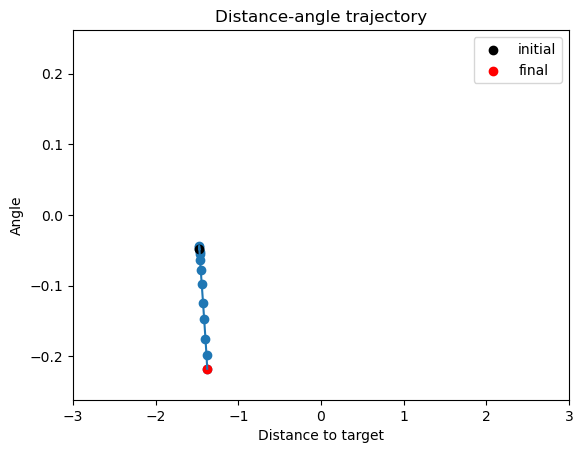

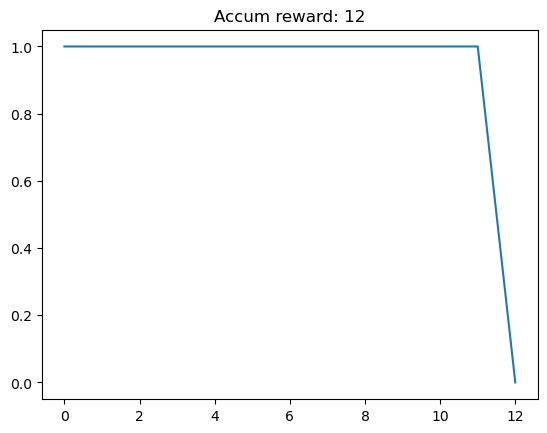

Episode length: 13


In [5]:
#TODO: passar inputs necessaris
analyze_results(historical_obs,rewards)

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Comentari:</strong>
<br><br>
</div>

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
    <strong>Exercici 0.3 (0.5 punts):</strong> Respecte al gràfic realitzat a l'apartat anterior, quina seria la trajectòria que realitzaria un agent que es comportés de manera òptima?
</div>

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Comentari:</strong>
<br>
    El gràfic corresponent a una política òptima és el d'un agent que es mou a prop del centre (0,0), mantenint un angle el més proper a 0 alhora que està el més a prop del target possible.
    <br>
</div>

# 1. Stable baselines 3 (2 pts)


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
    Comencem a entrenar un model per solucionar l'entorn. Recordeu que per als apartats 0 i 1 utilitzarem la reward default.
    Per solucionar l'entorn, utilitzarem el model A2C de la llibreria stable baselines.
</div>


In [6]:
from stable_baselines3 import A2C
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import EvalCallback
STEPS = 20_000
EVAL_FREQ = 2000
EVAL_EPISODES = 5

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
    <strong>Exercici 1.1 (0.25 punts):</strong> Entrena un model A2C amb paràmetres default i utilitzant una MlpPolicy per entrenar un agent que solucioni el cartpole amb reward default.
    Afegeix un callback per avaluar el model 5 vegades cada 2 mil iteracions.
    A més, fes que cada vegada que es trobi un model millor, es guardi el model. Utilitza la funció 'evaluate_policy' just abans d'entrenar el model per tenir una idea de com funciona el model abans de ser entrenat.
</div>


Opcional: Per a aquells que vulgueu aprofundir una mica més en l'assignatura, també existeix una eina anomenada TensorBoard, molt útil per analitzar el procés d'entrenament de qualsevol xarxa neuronal en general. Stable Baselines 3 té automatitzada la captura de logs amb TensorBoard. Per fer-ho, només cal que passeu al constructor del model el paràmetre tensorboard_log=path on vulgueu guardar el log. Podeu utilitzar aquests logs per veure no només les rewards d'evaluació, sinó també per veure els gradients, la loss i altres paràmetres durant l'entrenament.

Podeu utilitzar-lo en aquest apartat i en tots els que vulgueu durant la pràctica. No puntuïarà ni es tindrà en compte, però permet conèixer més en detall com s'està entrenant el model.

In [7]:
env = CartPoleEnvRandomTarget(render_mode=None, reward_function = 'default')

callback = EvalCallback(eval_env = env,
                        eval_freq = EVAL_FREQ ,
                        best_model_save_path = './logs/default-cartpole',
                        n_eval_episodes=EVAL_EPISODES)

model = A2C("MlpPolicy", env,tensorboard_log  = './logs/default-cartpole')

initial_eval = evaluate_policy(model,env,n_eval_episodes = EVAL_EPISODES,deterministic = True)

C:\Users\birth\Anaconda3\envs\RL_2024_PAC1\lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


In [8]:
#TODO: entrenar model
model.learn(total_timesteps=STEPS, callback = callback, progress_bar = True)

C:\Users\birth\Anaconda3\envs\RL_2024_PAC1\lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" 
for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Eval num_timesteps=2000, episode_reward=54.20 +/- 14.16

Episode length: 55.20 +/- 14.16

New best mean reward!

Eval num_timesteps=4000, episode_reward=106.80 +/- 35.88

Episode length: 107.80 +/- 35.88

New best mean reward!

Eval num_timesteps=6000, episode_reward=219.20 +/- 145.23

Episode length: 220.00 +/- 144.84

New best mean reward!

Eval num_timesteps=8000, episode_reward=228.00 +/- 146.58

Episode length: 228.80 +/- 146.21

New best mean reward!

Eval num_timesteps=10000, episode_reward=139.20 +/- 25.89

Episode length: 140.20 +/- 25.89

Eval num_timesteps=12000, episode_reward=384.40 +/- 120.19

Episode length: 385.00 +/- 119.80

New best mean reward!

Eval num_timesteps=14000, episode_reward=156.60 +/- 175.66

Episode length: 157.40 +/- 175.27

Eval num_timesteps=16000, episode_reward=76.20 +/- 45.21

Episode length: 77.20 +/- 45.21

Eval num_timesteps=18000, episode_reward=181.40 +/- 71.05

Episode length: 182.40 +/- 71.05

Eval num_timesteps=20000, episode_reward=179.40 +/- 166.71

Episode length: 180.20 +/- 166.33

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
    <strong>Exercici 1.2 (0.25 punts):</strong> Carrega el millor model trobat i executa la funció evaluate_policy. Compara les rewards inicials i finals.
    Executa un episodi i analitza els resultats utilitzant la funció prèviament creada per visualitzar el comportament de l'agent en l'espai d'angle-posició.
</div>


In [9]:
model = A2C.load('./logs/default-cartpole/best_model.zip')
final_eval = evaluate_policy(model,env,n_eval_episodes = EVAL_EPISODES,deterministic = True)
print (f'Initial evaluation: {initial_eval}')
print (f'Best model evaluation: {final_eval}')

Initial evaluation: (8.6, 0.48989794855663565)
Best model evaluation: (218.0, 89.6258891169287)


In [10]:
#TODO: Completar funcio d'avaluació del model entrenat
def evaluate_trained_model(env,model):
    #Primer executem un cop l'entorn
    obs,_ = env.reset()
    done = False
    total_reward = 0
    t = 0
    historical_observations = []
    rewards = []
    while not done:
        # TODO: Escollir accio en base al model
        action, _state = model.predict(obs, deterministic=True)
        # TODO: Executar accio i esperar resposta de l'entorn
        obs, reward, terminated,truncated, info = env.step(action)
        done = terminated or truncated
        # TODO: Guardar informacio necesaria per a poder fer les grafiques despres
        historical_observations.append(obs)
        rewards.append(reward)
        total_reward += reward
        t += 1
        # Renderitzem
        env.render()
        time.sleep(0.1) #S'afegeix per alentir el renderitzat i poder apreciar els moviments de l'agent
        
    #Analitzem resultats
    print("Epsisode finished in {} timesteps. Total reward: {}".format(t, total_reward))
    analyze_results(historical_observations,rewards)


Epsisode finished in 321 timesteps. Total reward: 320


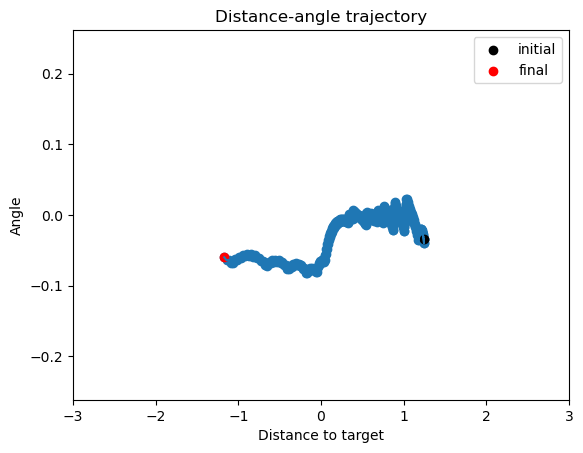

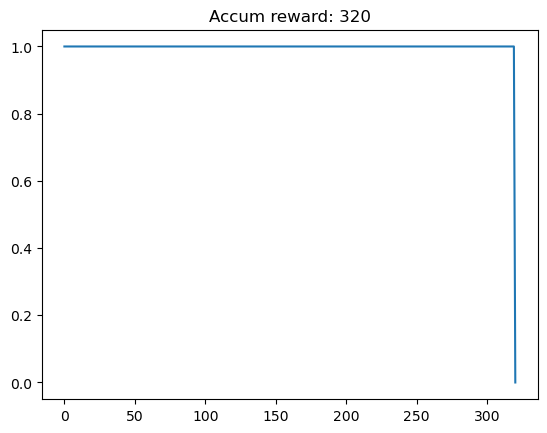

Episode length: 321


In [11]:
env = CartPoleEnvRandomTarget(render_mode='human',reward_function = 'default') #podeis hacer render mode = None
evaluate_trained_model(env,model)

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Comentari:</strong>
<br><br>
</div>

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
    <strong>Exercici 1.3 (0.5 punts):</strong> Un dels problemes que tenim amb aquest entorn és que estem avaluant el model sobre un entorn random. Això genera que durant el callback puguem guardar un model no perquè sigui millor que els anteriors, sinó perquè els entorns sobre els quals s'ha avaluat són més senzills. Per exemple, si en un dels callbacks el target es situa als extrems, tot i que l'agent es comporti millor que les seves versions anteriors, potser no ho sabrem perquè la reward total serà més petita que, per exemple, una versió amb un comportament pitjor, però en què el target s'ha situat al centre.
    Modifica l'entorn de cartpole (veure TODOS dins del codi) perquè en avaluació el target es trobi en 9 posicions diferents:
    <ul>
    <li> Als extrems</li>
    <li> A 3/4, 1/2 i 1/4 de la distància entre el centre i els extrems</li>
    <li> Just al centre</li>
    </ul>
    Setejarem a partir d'ara el número d'episodis d'avaluació a 18 (EVAL_EPISODES) perquè s'executi 2 vegades cada casuística.
</div>


In [12]:
"""
Classic cart-pole system implemented by Rich Sutton et al.
Copied from http://incompleteideas.net/sutton/book/code/pole.c
permalink: https://perma.cc/C9ZM-652R
"""

import math
from typing import Optional, Union

import numpy as np

import gymnasium as gym
from gymnasium import spaces
from gymnasium.envs.classic_control import utils
from gymnasium.error import DependencyNotInstalled



class CartPoleEnvRandomTarget(gym.Env[np.ndarray, Union[int, np.ndarray]]):
    """
    ## Description

    This environment corresponds to a modification of the version of the cart-pole problem described by Barto, Sutton, and Anderson in
    ["Neuronlike Adaptive Elements That Can Solve Difficult Learning Control Problem"](https://ieeexplore.ieee.org/document/6313077).
    A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track.
    The pendulum is placed upright on the cart and the goal is to balance the pole by applying forces
     in the left and right direction on the cart.
     The modification consists on a target appearing into scene. The cart must be as close to the target as posible

    For more details about original cartpole look for source code in gymnasium.
    """


    metadata = {
        "render_modes": ["human", "rgb_array"],
        "render_fps": 50,
    }

    def __init__(
        self,
        target_desire_factor: float = 0.5,
        reward_function: str = "default",
        is_eval=False,
        increased_actions=False,
        render_mode: Optional[str] = None,
    ):

        self.gravity = 9.8
        self.masscart = 1.0
        self.masspole = 0.1
        self.total_mass = self.masspole + self.masscart
        self.length = 0.5  # actually half the pole's length
        self.polemass_length = self.masspole * self.length
        self.force_mag = 10.0
        self.tau = 0.02  # seconds between state updates

        self.max_steps = 500
        self.steps = 0

        # Angle at which to fail the episode
        self.theta_threshold_radians = 12 * 2 * math.pi / 360
        self.x_threshold = 2.4
        self.target_threshold = 2

        high = np.array(
            [
                self.x_threshold * 2,
                np.inf,
                self.theta_threshold_radians * 2,
                np.inf,
                self.target_threshold * 2,
            ],
            dtype=np.float32,
        )
        self.increased_actions = increased_actions
        if self.increased_actions:
            #TODO 3.1: Ampliar l'espai d'observacions
            raise NotImplementedError("Increased actions should be implemented")
        else:
            self.action_space = spaces.Discrete(2)
        self.observation_space = spaces.Box(-high, high, dtype=np.float32)

        self.render_mode = render_mode

        self.screen_width = 600
        self.screen_height = 400
        self.screen = None
        self.clock = None
        self.isopen = True
        self.state: np.ndarray | None = None

        self.steps_beyond_terminated = None

        #TODO 1.3: Tenir en compte si l'entorn és d'avaluació
        self.is_eval = is_eval
        self.eval_counter = 0
        self.eval_tests = [
            -self.target_threshold,
            -3 * self.target_threshold / 4,
            -2 * self.target_threshold / 4,
            -1 * self.target_threshold / 4,
            0,
            1 * self.target_threshold / 4,
            2 * self.target_threshold / 4,
            3 * self.target_threshold / 4,
            self.target_threshold,
        ]
        self.target_position = self.generate_random_target_position()

        self.target_desire_factor = min(
            max(target_desire_factor, 0), 1
        )  # between 0 and 1
        if reward_function in ["default", "custom"]:
            self.reward_function = reward_function
        else:
            raise AttributeError("reward function must be either default or custom")

    def generate_random_target_position(
        self,
    ):
        if self.is_eval:
            #TODO 1.3:Tingueu en compte si l'entorn és d'avaluació per situar el target en unes posicions concretes.
            target_position = self.eval_tests[self.eval_counter % len(self.eval_tests)]
            self.eval_counter += 1
            return target_position
        else:
            return np.random.uniform(-self.x_threshold, self.x_threshold)

    def custom_reward(self, target_position, current_position, angle, terminated):
        if self.reward_function == "default":
            #Reward default del cartpole
            return 1 if not terminated else 0
        else:
            angle_reward = (
                -abs(angle) / (2.0 * self.x_threshold) / self.theta_threshold_radians
            )
            target_reward = -(abs(target_position - current_position) ** 2) / (
                (2 * self.x_threshold) ** 2
            )
            return (
                1
                + self.target_desire_factor * target_reward
                + (1 - self.target_desire_factor) * angle_reward
            )
        #TODO 2.2: Implementar 2 funcions de reward extra

    def step(self, action):
        assert self.action_space.contains(
            action
        ), f"{action!r} ({type(action)}) invalid"
        assert self.state is not None, "Call reset before using step method."
        x, x_dot, theta, theta_dot, _ = self.state
        if self.increased_actions:
            force_factor = action - 3
            force = (
                force_factor / 3 * self.force_mag
                if force_factor > 0
                else (force_factor - 1) / 3 * self.force_mag
            )
        else:
            force = self.force_mag if action == 1 else -self.force_mag
        costheta = np.cos(theta)
        sintheta = np.sin(theta)

        # For the interested reader:
        # https://coneural.org/florian/papers/05_cart_pole.pdf
        temp = (
            force + self.polemass_length * np.square(theta_dot) * sintheta
        ) / self.total_mass
        thetaacc = (self.gravity * sintheta - costheta * temp) / (
            self.length
            * (4.0 / 3.0 - self.masspole * np.square(costheta) / self.total_mass)
        )
        xacc = temp - self.polemass_length * thetaacc * costheta / self.total_mass

        x = x + self.tau * x_dot
        x_dot = x_dot + self.tau * xacc
        theta = theta + self.tau * theta_dot
        theta_dot = theta_dot + self.tau * thetaacc

        self.state = np.array(
            (x, x_dot, theta, theta_dot, self.target_position), dtype=np.float64
        ) #Aquest estat es diferent respecte al del cartpole original

        terminated = bool(
            x < -self.x_threshold
            or x > self.x_threshold
            or theta < -self.theta_threshold_radians
            or theta > self.theta_threshold_radians
        )

        reward = self.custom_reward(self.target_position, x, theta, terminated)

        if self.render_mode == "human":
            self.render()

        # truncation=False as the time limit is handled by the `TimeLimit` wrapper added during `make`
        self.steps += 1
        if self.steps >= self.max_steps:
            truncated = True
        else:
            truncated = False
        return np.array(self.state, dtype=np.float32), reward, terminated, truncated, {}

    def reset(
        self,
        *,
        seed: Optional[int] = None,
        options: Optional[dict] = None,
    ):

        super().reset(seed=seed)
        self.steps = 0
        # Note that if you use custom reset bounds, it may lead to out-of-bound
        # state/observations.
        low, high = utils.maybe_parse_reset_bounds(
            options, -0.05, 0.05  # default low
        )  # default high

        self.state = self.np_random.uniform(low=low, high=high, size=(4,)).tolist()
        self.steps_beyond_terminated = None

        #Generar posició aleatòria del target i guardar en l'estat
        self.target_position = self.generate_random_target_position()
        self.state.append(self.target_position)

        self.state = np.array(self.state)
        if self.render_mode == "human":
            self.render()
        return np.array(self.state, dtype=np.float32), {}

    def render(self):
        if self.render_mode is None:
            assert self.spec is not None
            gym.logger.warn(
                "You are calling render method without specifying any render mode. "
                "You can specify the render_mode at initialization, "
                f'e.g. gym.make("{self.spec.id}", render_mode="rgb_array")'
            )
            return

        try:
            import pygame
            from pygame import gfxdraw
        except ImportError as e:
            raise DependencyNotInstalled(
                'pygame is not installed, run `pip install "gymnasium[classic-control]"`'
            ) from e

        if self.screen is None:
            pygame.init()
            if self.render_mode == "human":
                pygame.display.init()
                self.screen = pygame.display.set_mode(
                    (self.screen_width, self.screen_height)
                )
            else:  # mode == "rgb_array"
                self.screen = pygame.Surface((self.screen_width, self.screen_height))
        if self.clock is None:
            self.clock = pygame.time.Clock()

        world_width = self.x_threshold * 2
        scale = self.screen_width / world_width
        polewidth = 10.0
        polelen = scale * (2 * self.length)
        cartwidth = 50.0
        cartheight = 30.0
        targetwidth = 10
        targetheight = 10

        if self.state is None:
            return None

        x = self.state

        self.surf = pygame.Surface((self.screen_width, self.screen_height))
        self.surf.fill((255, 255, 255))

        l, r, t, b = -cartwidth / 2, cartwidth / 2, cartheight / 2, -cartheight / 2
        axleoffset = cartheight / 4.0
        cartx = x[0] * scale + self.screen_width / 2.0  # MIDDLE OF CART
        carty = 100  # TOP OF CART
        cart_coords = [(l, b), (l, t), (r, t), (r, b)]
        cart_coords = [(c[0] + cartx, c[1] + carty) for c in cart_coords]
        gfxdraw.aapolygon(self.surf, cart_coords, (0, 0, 0))
        gfxdraw.filled_polygon(self.surf, cart_coords, (0, 0, 0))

        l, r, t, b = (
            -polewidth / 2,
            polewidth / 2,
            polelen - polewidth / 2,
            -polewidth / 2,
        )

        pole_coords = []
        for coord in [(l, b), (l, t), (r, t), (r, b)]:
            coord = pygame.math.Vector2(coord).rotate_rad(-x[2])
            coord = (coord[0] + cartx, coord[1] + carty + axleoffset)
            pole_coords.append(coord)
        gfxdraw.aapolygon(self.surf, pole_coords, (202, 152, 101))
        gfxdraw.filled_polygon(self.surf, pole_coords, (202, 152, 101))

        gfxdraw.aacircle(
            self.surf,
            int(cartx),
            int(carty + axleoffset),
            int(polewidth / 2),
            (129, 132, 203),
        )
        gfxdraw.filled_circle(
            self.surf,
            int(cartx),
            int(carty + axleoffset),
            int(polewidth / 2),
            (129, 132, 203),
        )

        l, r, t, b = (
            -targetwidth / 2,
            targetwidth / 2,
            targetheight / 2,
            -targetheight / 2,
        )
        axleoffset = targetheight / 4.0
        targetx = x[-1] * scale + self.screen_width / 2.0  # MIDDLE OF target
        targety = 90  # TOP OF target
        target_coords = [(l, b), (l, t), (r, t), (r, b)]
        target_coords = [(c[0] + targetx, c[1] + targety) for c in target_coords]
        gfxdraw.aapolygon(self.surf, target_coords, (10, 255, 10))
        gfxdraw.filled_polygon(self.surf, target_coords, (10, 255, 10))

        gfxdraw.hline(self.surf, 0, self.screen_width, carty, (0, 0, 0))

        self.surf = pygame.transform.flip(self.surf, False, True)
        self.screen.blit(self.surf, (0, 0))
        if self.render_mode == "human":
            pygame.event.pump()
            self.clock.tick(self.metadata["render_fps"])
            pygame.display.flip()

        elif self.render_mode == "rgb_array":
            return np.transpose(
                np.array(pygame.surfarray.pixels3d(self.screen)), axes=(1, 0, 2)
            )

    def close(self):
        if self.screen is not None:
            import pygame

            pygame.display.quit()
            pygame.quit()
            self.isopen = False

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
    <strong>Exercici 1.4.1 (0.5 punts):</strong> Modifica la funció analyze_results perquè creï els mateixos gràfics que es generaven abans però per a cada casuística. Suposa que a la funció li arribaran 9 episodis diferents, 1 per a cada casuística. Podeu utilitzar subplots de matplotlib. Us hauria de quedar alguna cosa així:
</div>


![image-3.png](exemple_sortida.png)

In [13]:
def analyze_results(test_cases_observations,test_cases_rewards):
    #TODO: Completar nova funció que genera un subplot amb una gràfica per test case
    fig, axs = plt.subplots(2, 5, figsize = (20,10))
    fig_rewrds, axs_rewards = plt.subplots(2,5,figsize = (20,10))
    n_eval_cases = len(test_cases_observations)
    for i in range(n_eval_cases):
        historical_observations = np.array(test_cases_observations[i])
        position = historical_observations[:,0]
        target = historical_observations[:,-1]
        theta = historical_observations[:,2]

        rewards = np.array(test_cases_rewards[i])

        row,col = i//5, i%5
        axs[row,col].plot(position,theta)
        #axs[row,col].scatter(position,theta)
        axs[row,col].scatter([position[0]],[theta[0]],c = 'darkgreen',label = 'initial')
        axs[row,col].scatter([position[-1]],[theta[-1]],c = 'red',label = 'final')
        axs[row,col].scatter([target[0]],[0],marker = '+',c = 'black')

        if i==0:
            axs[row,col].set_xlabel('Position')
            axs[row,col].set_ylabel('Angle')
            axs[row,col].set_title('Position-angle trajectory')
            axs[row,col].legend()
        axs[row,col].set_ylim(-ANGLE_THRESHOLD,ANGLE_THRESHOLD)
        axs[row,col].set_xlim(-X_THRESHOLD,X_THRESHOLD)
        axs_rewards[row,col].plot(rewards)
        axs_rewards[row,col].set_title(f'Accum reward: {sum(rewards):.2f}')
        axs_rewards[row,col].set_xlim(0,500)
    plt.show()

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
    <strong>Exercici 1.4.2 (0.5 punts):</strong> Repeteix els exercicis 1.1 i 1.2 però avaluant amb un entorn d'avaluació i utilitzant la nova funció d'avaluació. Recorda que tot i que els EVAL_EPISODES són 18, per avaluar l'agent i fer els gràfics executarem 1 vegada cada casuística, fent un total de 9 execucions.
</div>


In [14]:
#Modificar primer els TODOS de l'entorn
EVAL_EPISODES = 18
env = CartPoleEnvRandomTarget(render_mode=None,reward_function = 'default')
eval_env = CartPoleEnvRandomTarget(render_mode=None,reward_function = 'default',is_eval = True)

#TODO: Completar codi
#Creem callback i model. Per al callback farem servir l'entorn d'evaluacio, per al model el normal
callback = EvalCallback(eval_env = eval_env,
                        eval_freq = EVAL_FREQ,
                        n_eval_episodes = EVAL_EPISODES,
                        deterministic = True,
                        best_model_save_path = './logs/default-cartpole-eval')

model = A2C("MlpPolicy", env,tensorboard_log  = './logs/default-cartpole-eval')

#Executem evaluacio inicial
initial_eval = evaluate_policy(model,env,n_eval_episodes = EVAL_EPISODES,deterministic = True)

#Entrenem model
model.learn(total_timesteps=STEPS,
            callback = callback,
            progress_bar = True)

Eval num_timesteps=2000, episode_reward=74.11 +/- 83.81

Episode length: 75.11 +/- 83.81

New best mean reward!

Eval num_timesteps=4000, episode_reward=205.06 +/- 160.82

Episode length: 205.83 +/- 160.42

New best mean reward!

Eval num_timesteps=6000, episode_reward=61.06 +/- 29.07

Episode length: 62.06 +/- 29.07

Eval num_timesteps=8000, episode_reward=128.44 +/- 136.94

Episode length: 129.33 +/- 136.64

Eval num_timesteps=10000, episode_reward=150.22 +/- 129.69

Episode length: 151.11 +/- 129.39

Eval num_timesteps=12000, episode_reward=438.28 +/- 66.51

Episode length: 438.83 +/- 66.09

New best mean reward!

Eval num_timesteps=14000, episode_reward=162.22 +/- 126.26

Episode length: 163.11 +/- 125.96

Eval num_timesteps=16000, episode_reward=263.44 +/- 151.09

Episode length: 264.22 +/- 150.75

Eval num_timesteps=18000, episode_reward=454.67 +/- 65.73

Episode length: 455.11 +/- 65.35

New best mean reward!

Eval num_timesteps=20000, episode_reward=395.06 +/- 121.95

Episode length: 395.50 +/- 121.47

In [15]:
#Carreguem millor model i executem validacio final
model = A2C.load('./logs/default-cartpole-eval/best_model.zip')
final_eval = evaluate_policy(model,eval_env,n_eval_episodes = EVAL_EPISODES,deterministic = True)
print (f'Initial evaluation: {initial_eval}')
print (f'Best model evaluation: {final_eval}')

Initial evaluation: (8.444444444444445, 0.9558139185602919)
Best model evaluation: (468.94444444444446, 58.242283439498785)


 11%|█████████▎                                                                          | 1/9 [00:20<02:45, 20.64s/it]

Epsisode finished in 500 timesteps. Total reward: 500


 22%|██████████████████▋                                                                 | 2/9 [00:41<02:24, 20.62s/it]

Epsisode finished in 500 timesteps. Total reward: 500


 33%|████████████████████████████                                                        | 3/9 [00:56<01:48, 18.09s/it]

Epsisode finished in 368 timesteps. Total reward: 367


 44%|█████████████████████████████████████▎                                              | 4/9 [01:12<01:27, 17.46s/it]

Epsisode finished in 403 timesteps. Total reward: 402


 56%|██████████████████████████████████████████████▋                                     | 5/9 [01:30<01:10, 17.61s/it]

Epsisode finished in 438 timesteps. Total reward: 437


 67%|████████████████████████████████████████████████████████                            | 6/9 [01:51<00:55, 18.57s/it]

Epsisode finished in 500 timesteps. Total reward: 500


 78%|█████████████████████████████████████████████████████████████████▎                  | 7/9 [02:06<00:34, 17.39s/it]

Epsisode finished in 366 timesteps. Total reward: 365


 89%|██████████████████████████████████████████████████████████████████████████▋         | 8/9 [02:19<00:16, 16.20s/it]

Epsisode finished in 332 timesteps. Total reward: 331


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [02:40<00:00, 17.81s/it]

Epsisode finished in 500 timesteps. Total reward: 500


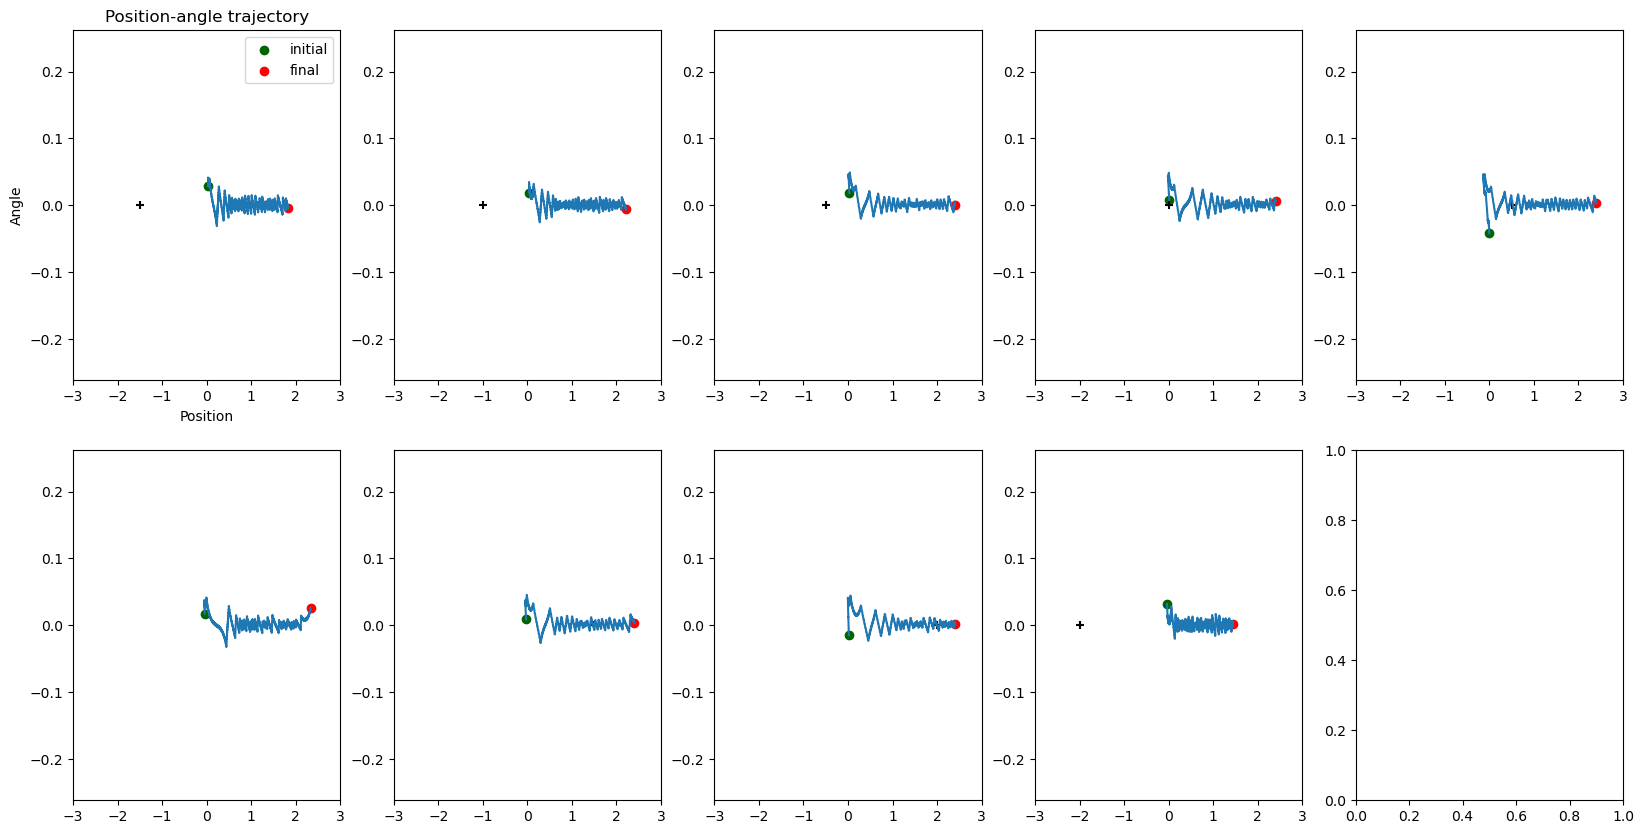

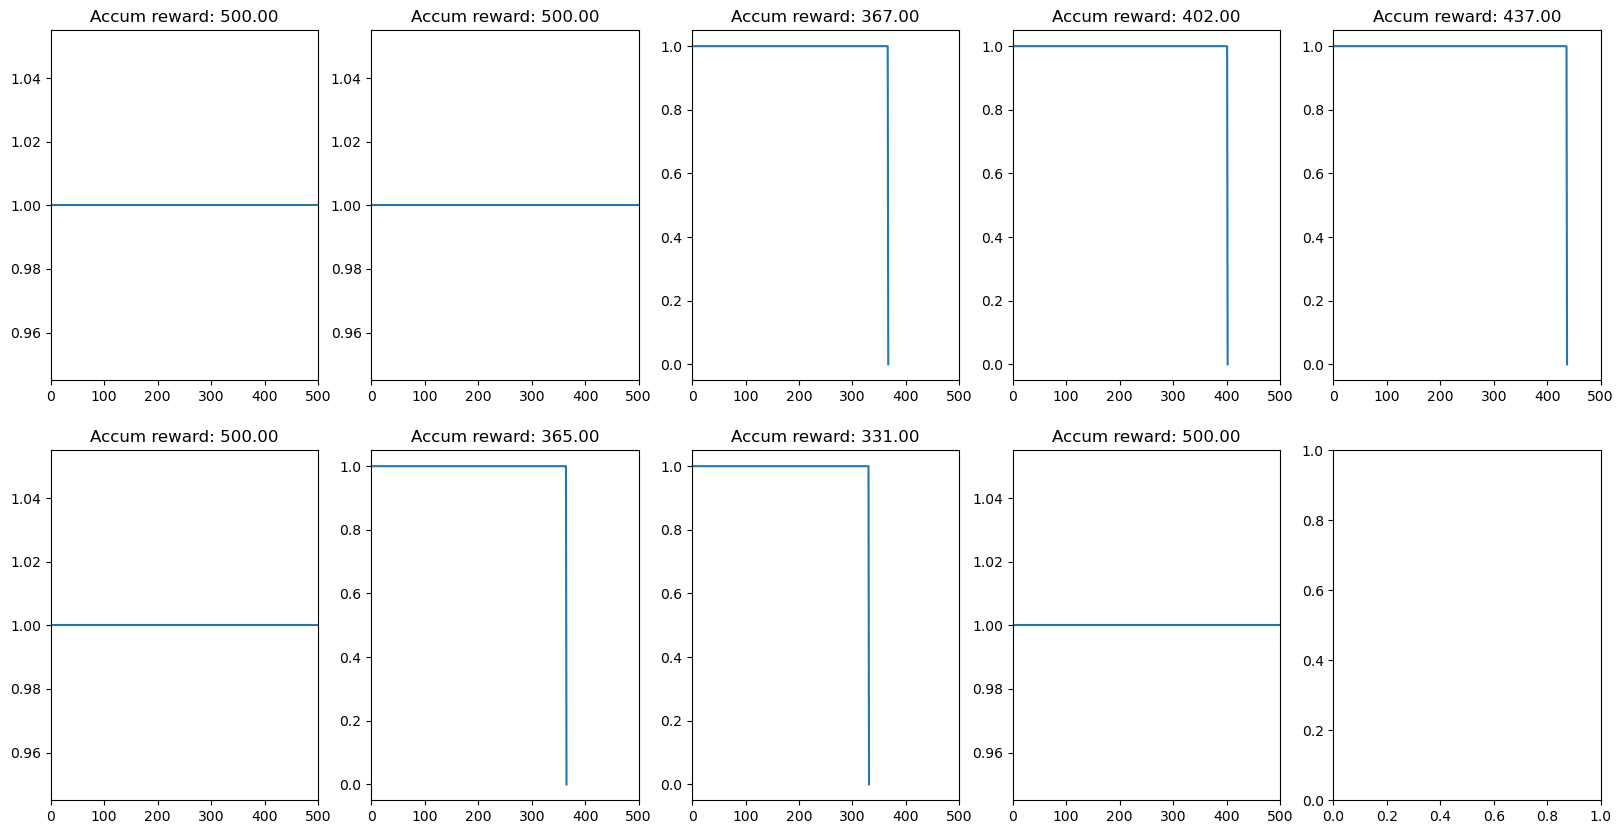

In [16]:
from tqdm import tqdm

def evaluate_trained_model(env,model):
    #TODO: Completar funció
    obs,_ = env.reset()
    #Fem un for loop per tots els tests cases i guardem resultats
    n_eval_cases = 9
    test_cases_observations = []
    test_cases_rewards = []
    for _ in tqdm(range(n_eval_cases)):
        done = False
        historical_observations = []
        rewards = []
        t = 0
        total_reward = 0
        #Executar el primer test case i guardar
        while not done:
            # Escollir accio en base al model
            action, _state = model.predict(obs, deterministic=True)
            # Executar accio i esperar resposta de l'entorn
            obs, reward, terminated,truncated, info = env.step(action)
            done = terminated or truncated
            # Guardar informacio necesaria per a poder fer les grafiques despres
            historical_observations.append(obs)
            rewards.append(reward)
            total_reward += reward
            t += 1
            # Renderitzem
            env.render()
            #time.sleep(0.1) #S'afegeix per alentir el renderitzat i poder apreciar els moviments de l'agent

        test_cases_observations.append(historical_observations)
        test_cases_rewards.append(rewards)
        obs,_ = env.reset()

        print("Epsisode finished in {} timesteps. Total reward: {}".format(t, total_reward))

    #Executem la funció analyze results
    analyze_results(test_cases_observations,test_cases_rewards)

#Executem la funcio
eval_env = CartPoleEnvRandomTarget(render_mode='human',reward_function = 'default',is_eval = True) #podeis modificar el render mode a None
evaluate_trained_model(eval_env,model)

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Comentari:</strong>
<br><br>
</div>

# 2. Efecte del reward (3 pts)

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
    <strong>Exercici 2.1 (1.25 punts):</strong> Entrena un agent utilitzant diferents valors del paràmetre target_desire_factor:
    <ul>
        <li>target_desire_factor=0</li>
        <li>target_desire_factor=0.5</li>
        <li>target_desire_factor=1</li>
    </ul>

Executa un episodi amb el millor agent (recorda utilitzar els callbacks) i comenta els resultats obtinguts.
</div>


In [17]:
env = CartPoleEnvRandomTarget(render_mode=None,reward_function = 'custom',target_desire_factor=0)#Modificar target_desire_factor
eval_env = CartPoleEnvRandomTarget(render_mode=None,reward_function = 'custom',target_desire_factor=0,is_eval = True)#Modificar target_desire_factor

#TODO: Repetir el mateix que en els exercicis anteriors. Callback, model, avaluació inicial, càrrega del millor model i entrenament.
#Al final, analitzar els resultats utilitzant la funció evaluate_trained_model.
#Repetir per a cada valor de target_desire_factor.
callback = EvalCallback(eval_env = eval_env,
                        eval_freq = EVAL_FREQ,
                        n_eval_episodes = EVAL_EPISODES,
                        deterministic = True,
                        best_model_save_path = './logs/custom-cartpole-desire-0')

model = A2C("MlpPolicy", env,tensorboard_log  = './logs/custom-cartpole-desire-0')

initial_eval = evaluate_policy(model,eval_env,n_eval_episodes = EVAL_EPISODES,deterministic = True)
model.learn(total_timesteps=STEPS,
            callback = callback,
            progress_bar = True)
model = A2C.load('./logs/custom-cartpole-desire-0/best_model.zip')
final_eval = evaluate_policy(model,eval_env,n_eval_episodes = EVAL_EPISODES,deterministic = True)

Eval num_timesteps=2000, episode_reward=82.03 +/- 26.18

Episode length: 90.22 +/- 27.39

New best mean reward!

Eval num_timesteps=4000, episode_reward=62.96 +/- 53.05

Episode length: 69.89 +/- 56.99

Eval num_timesteps=6000, episode_reward=195.71 +/- 32.65

Episode length: 202.22 +/- 32.75

New best mean reward!

Eval num_timesteps=8000, episode_reward=239.80 +/- 156.00

Episode length: 247.33 +/- 153.62

New best mean reward!

Eval num_timesteps=10000, episode_reward=99.79 +/- 12.90

Episode length: 113.94 +/- 12.28

Eval num_timesteps=12000, episode_reward=136.67 +/- 140.39

Episode length: 143.11 +/- 140.18

Eval num_timesteps=14000, episode_reward=147.32 +/- 117.97

Episode length: 156.44 +/- 119.24

Eval num_timesteps=16000, episode_reward=401.09 +/- 76.28

Episode length: 405.78 +/- 75.62

New best mean reward!

Eval num_timesteps=18000, episode_reward=375.59 +/- 147.42

Episode length: 383.39 +/- 144.17

Eval num_timesteps=20000, episode_reward=360.33 +/- 86.21

Episode length: 366.50 +/- 85.46

Initial evaluation: (42.20410779780812, 23.806244778893713)
Best model evaluation: (404.4117570552561, 98.68696136287163)


 11%|█████████▎                                                                          | 1/9 [00:20<02:45, 20.64s/it]

Epsisode finished in 500 timesteps. Total reward: 497.96292480091194


 22%|██████████████████▋                                                                 | 2/9 [00:40<02:19, 19.94s/it]

Epsisode finished in 471 timesteps. Total reward: 466.47302959160044


 33%|████████████████████████████                                                        | 3/9 [00:57<01:52, 18.72s/it]

Epsisode finished in 418 timesteps. Total reward: 413.415570402163


 44%|█████████████████████████████████████▎                                              | 4/9 [01:15<01:32, 18.50s/it]

Epsisode finished in 440 timesteps. Total reward: 433.8273020942853


 56%|██████████████████████████████████████████████▋                                     | 5/9 [01:29<01:07, 16.75s/it]

Epsisode finished in 331 timesteps. Total reward: 327.0612780487644


 67%|████████████████████████████████████████████████████████                            | 6/9 [01:43<00:48, 16.07s/it]

Epsisode finished in 357 timesteps. Total reward: 351.6471176125094


 78%|█████████████████████████████████████████████████████████████████▎                  | 7/9 [01:59<00:31, 15.80s/it]

Epsisode finished in 368 timesteps. Total reward: 361.17652680057074


 89%|██████████████████████████████████████████████████████████████████████████▋         | 8/9 [02:11<00:14, 14.73s/it]

Epsisode finished in 302 timesteps. Total reward: 296.04761782072967


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [02:32<00:00, 16.91s/it]

Epsisode finished in 500 timesteps. Total reward: 497.5552830336101


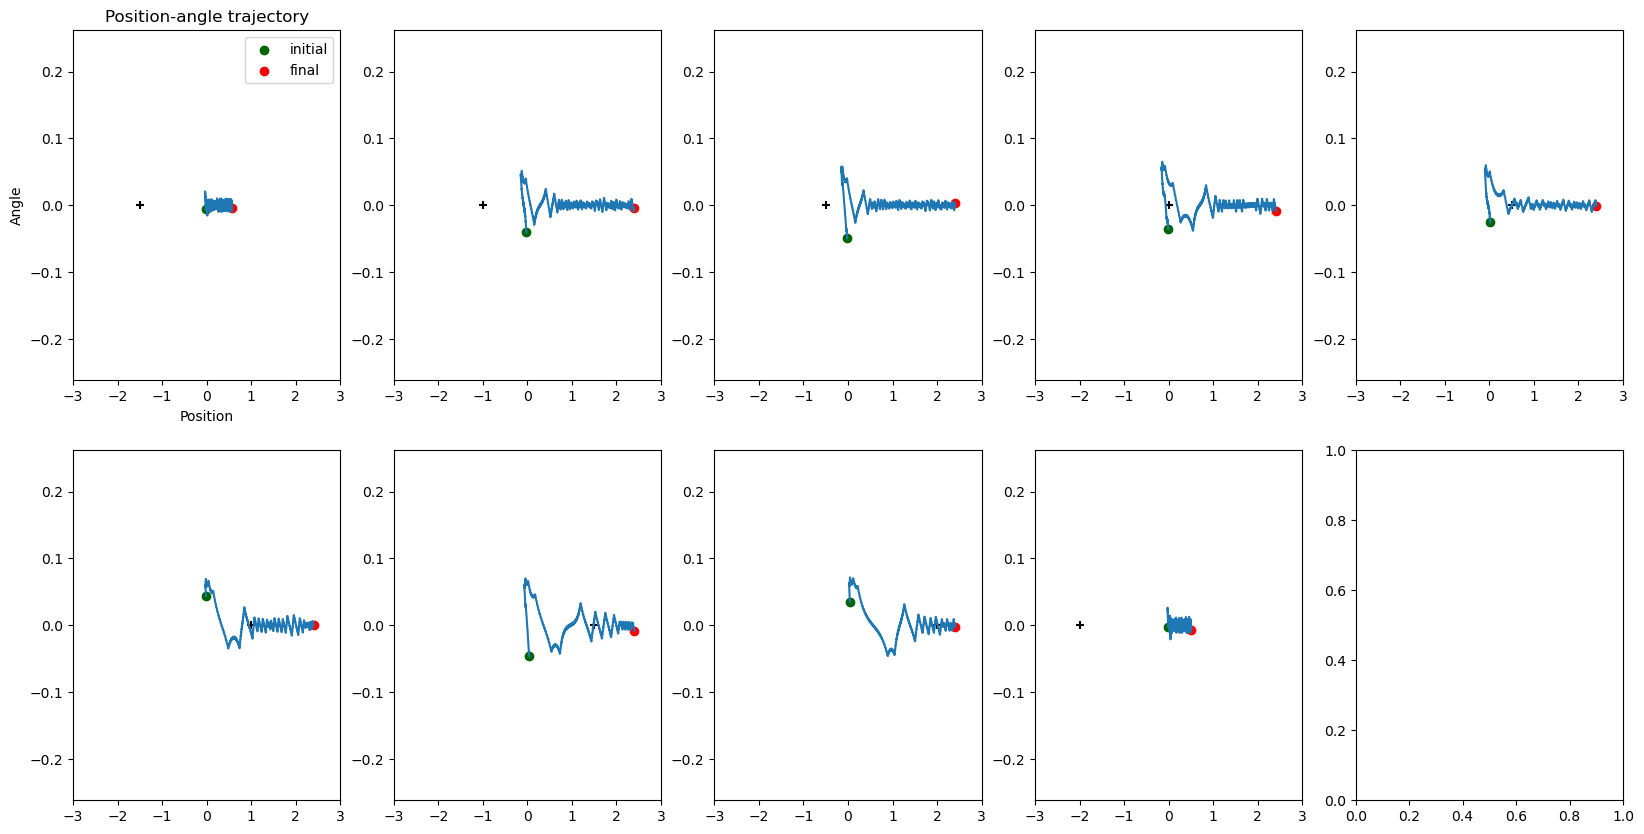

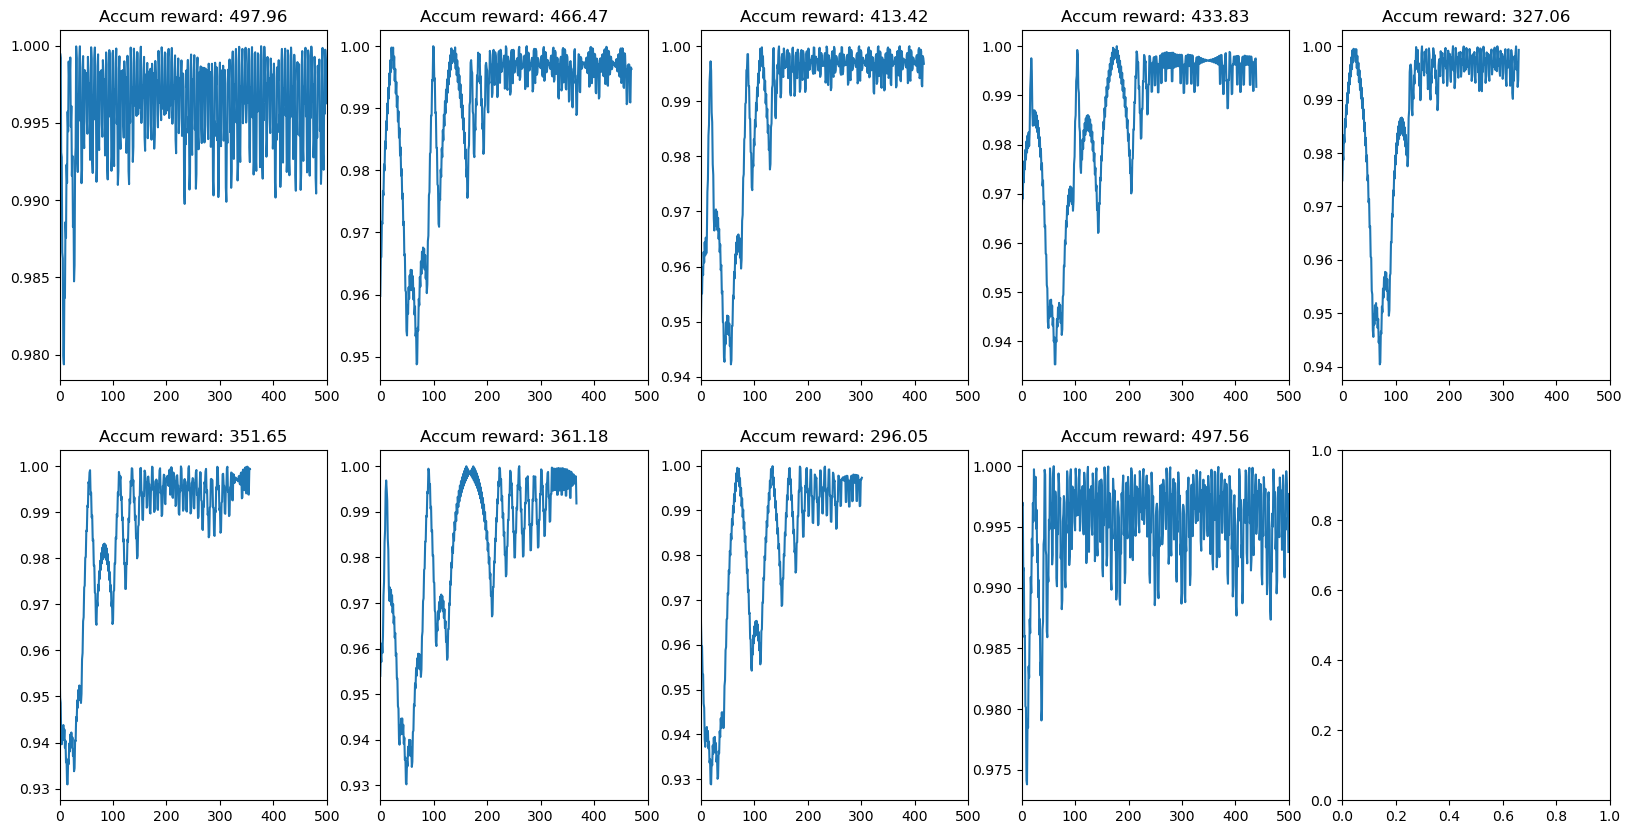

In [18]:
print (f'Initial evaluation: {initial_eval}')
print (f'Best model evaluation: {final_eval}')
env = CartPoleEnvRandomTarget(render_mode='human',reward_function = 'custom',target_desire_factor=0,is_eval = True)
evaluate_trained_model(env,model)

In [19]:
env = CartPoleEnvRandomTarget(render_mode=None,reward_function = 'custom',target_desire_factor=0.5)
eval_env = CartPoleEnvRandomTarget(render_mode=None,reward_function = 'custom',target_desire_factor=0.5,is_eval = True)

callback = EvalCallback(eval_env = eval_env,
                        eval_freq = EVAL_FREQ ,
                        n_eval_episodes = EVAL_EPISODES,
                        deterministic = True,
                        best_model_save_path = './logs/custom-cartpole-desire-05/')

model = A2C("MlpPolicy", env,tensorboard_log  = './logs/custom-cartpole-desire-05/')

initial_eval = evaluate_policy(model,eval_env,n_eval_episodes = EVAL_EPISODES,deterministic = True)
model.learn(total_timesteps=STEPS,
            callback = callback,
            progress_bar = True)
model = A2C.load('./logs/custom-cartpole-desire-05/best_model.zip')
final_eval = evaluate_policy(model,eval_env,n_eval_episodes = EVAL_EPISODES,deterministic = True)

Eval num_timesteps=2000, episode_reward=59.03 +/- 48.00

Episode length: 64.33 +/- 54.04

New best mean reward!

Eval num_timesteps=4000, episode_reward=69.64 +/- 31.42

Episode length: 74.61 +/- 31.27

New best mean reward!

Eval num_timesteps=6000, episode_reward=81.21 +/- 53.02

Episode length: 86.50 +/- 52.80

New best mean reward!

Eval num_timesteps=8000, episode_reward=133.00 +/- 154.98

Episode length: 139.78 +/- 156.91

New best mean reward!

Eval num_timesteps=10000, episode_reward=157.73 +/- 183.32

Episode length: 163.61 +/- 185.40

New best mean reward!

Eval num_timesteps=12000, episode_reward=275.89 +/- 168.68

Episode length: 284.61 +/- 167.19

New best mean reward!

Eval num_timesteps=14000, episode_reward=151.54 +/- 108.44

Episode length: 164.56 +/- 106.27

Eval num_timesteps=16000, episode_reward=197.54 +/- 122.11

Episode length: 208.06 +/- 122.56

Eval num_timesteps=18000, episode_reward=201.13 +/- 115.19

Episode length: 220.33 +/- 115.97

Eval num_timesteps=20000, episode_reward=155.63 +/- 133.72

Episode length: 170.28 +/- 129.14

Initial evaluation: (17.490948018100525, 18.60285790616883)
Best model evaluation: (268.7589705222183, 164.0245343696583)


 11%|█████████▎                                                                          | 1/9 [00:06<00:50,  6.33s/it]

Epsisode finished in 153 timesteps. Total reward: 145.31559311921657


 22%|██████████████████▋                                                                 | 2/9 [00:26<01:43, 14.73s/it]

Epsisode finished in 500 timesteps. Total reward: 491.63475659577585


 33%|████████████████████████████                                                        | 3/9 [00:47<01:44, 17.41s/it]

Epsisode finished in 500 timesteps. Total reward: 494.3778765377866


 44%|█████████████████████████████████████▎                                              | 4/9 [01:08<01:33, 18.67s/it]

Epsisode finished in 500 timesteps. Total reward: 489.9222746994181


 56%|██████████████████████████████████████████████▋                                     | 5/9 [01:20<01:06, 16.50s/it]

Epsisode finished in 307 timesteps. Total reward: 295.4668048191956


 67%|████████████████████████████████████████████████████████                            | 6/9 [01:27<00:39, 13.02s/it]

Epsisode finished in 152 timesteps. Total reward: 144.06416732086757


 78%|█████████████████████████████████████████████████████████████████▎                  | 7/9 [01:32<00:20, 10.47s/it]

Epsisode finished in 126 timesteps. Total reward: 117.20365187219565


 89%|██████████████████████████████████████████████████████████████████████████▋         | 8/9 [01:36<00:08,  8.48s/it]

Epsisode finished in 102 timesteps. Total reward: 90.64835178129903


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [01:42<00:00, 11.34s/it]

Epsisode finished in 134 timesteps. Total reward: 122.01789511898488


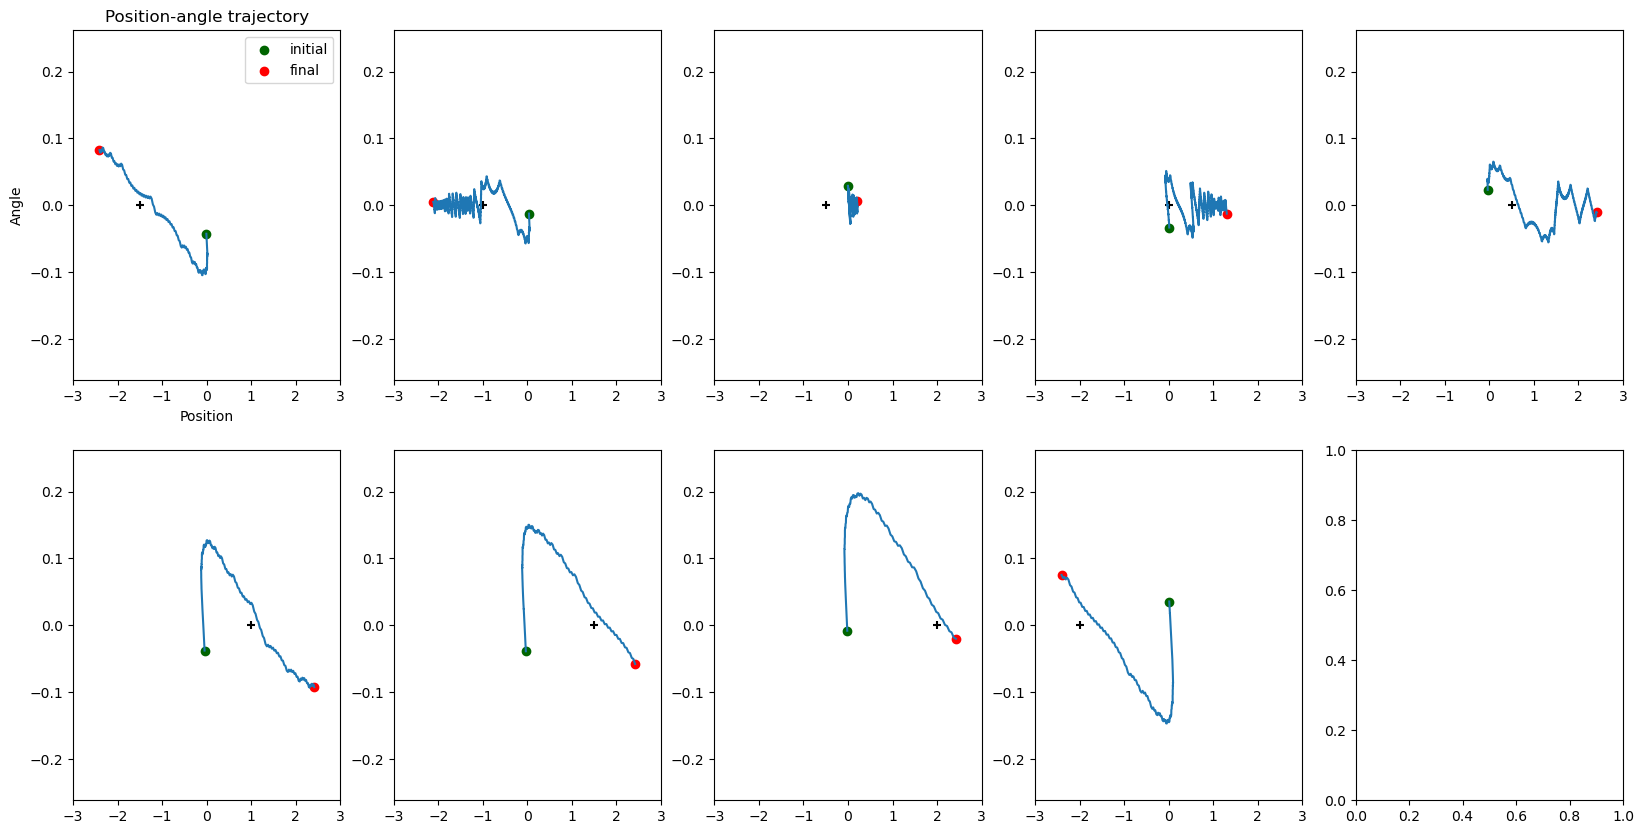

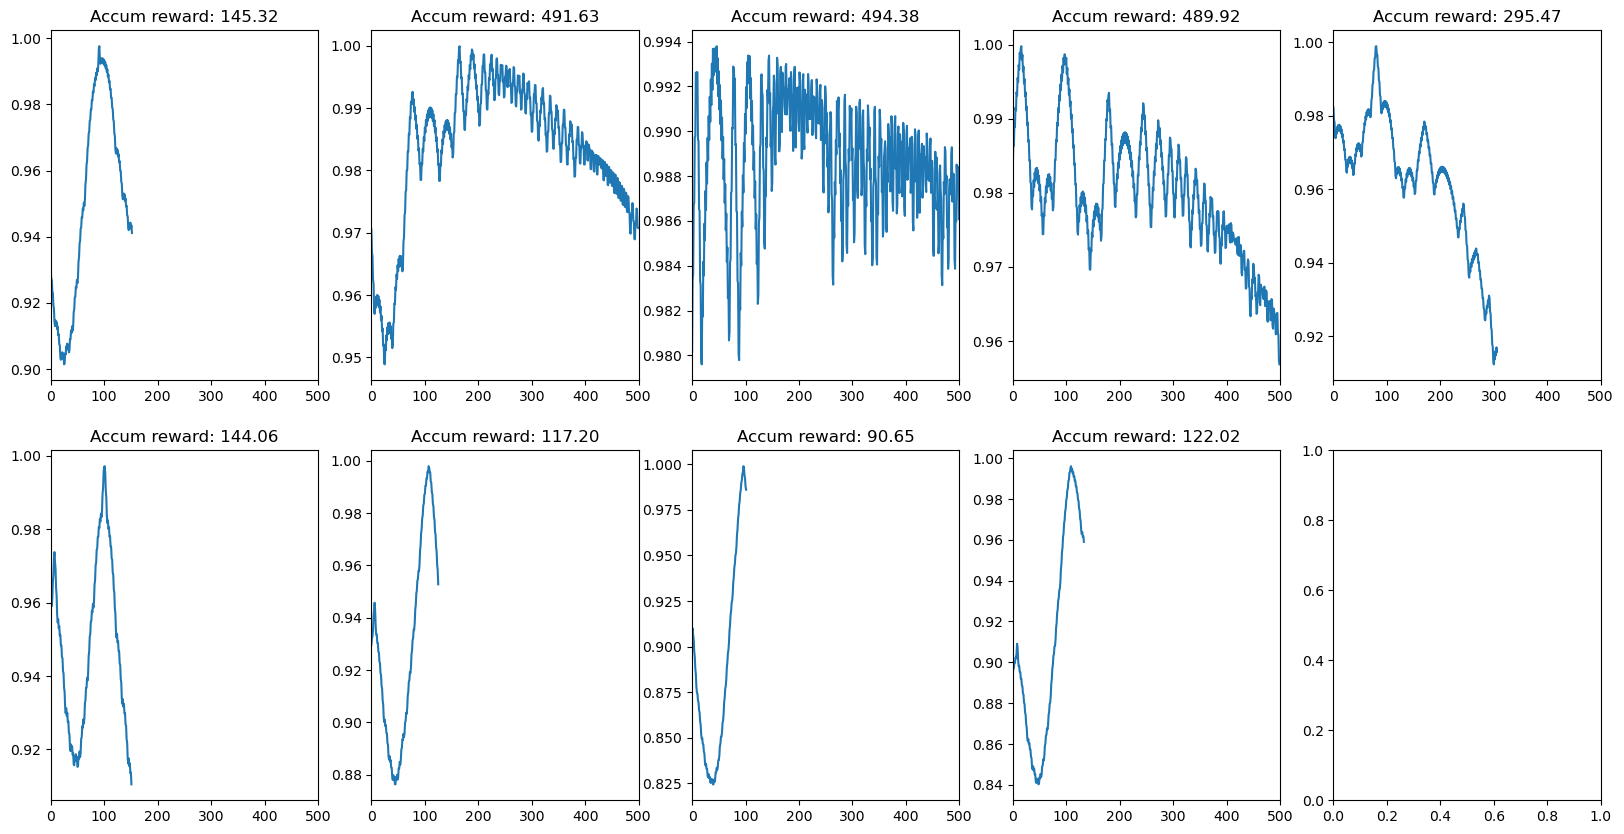

In [20]:
print (f'Initial evaluation: {initial_eval}')
print (f'Best model evaluation: {final_eval}')

env = CartPoleEnvRandomTarget(render_mode='human',reward_function = 'custom',target_desire_factor=0.5,is_eval = True)
evaluate_trained_model(env,model)

In [21]:
env = CartPoleEnvRandomTarget(render_mode=None,reward_function = 'custom',target_desire_factor=1)
eval_env = CartPoleEnvRandomTarget(render_mode=None,reward_function = 'custom',target_desire_factor=1,is_eval = True)

callback = EvalCallback(eval_env = eval_env,
                        eval_freq = EVAL_FREQ,
                        n_eval_episodes = EVAL_EPISODES,
                        deterministic = True,
                        best_model_save_path = './logs/custom-cartpole-desire-1/')

model = A2C("MlpPolicy", env,tensorboard_log  = './logs/custom-cartpole-desire-1/')

initial_eval = evaluate_policy(model,eval_env,n_eval_episodes = EVAL_EPISODES,deterministic = True)
model.learn(total_timesteps=STEPS,
            callback = callback,
            progress_bar = True)

Eval num_timesteps=2000, episode_reward=61.65 +/- 57.08

Episode length: 63.89 +/- 56.58

New best mean reward!

Eval num_timesteps=4000, episode_reward=119.44 +/- 85.17

Episode length: 125.89 +/- 86.11

New best mean reward!

Eval num_timesteps=6000, episode_reward=125.51 +/- 113.91

Episode length: 133.17 +/- 112.48

New best mean reward!

Eval num_timesteps=8000, episode_reward=391.33 +/- 114.57

Episode length: 398.83 +/- 110.39

New best mean reward!

Eval num_timesteps=10000, episode_reward=470.10 +/- 56.83

Episode length: 476.72 +/- 53.57

New best mean reward!

Eval num_timesteps=12000, episode_reward=87.79 +/- 90.19

Episode length: 92.22 +/- 92.87

Eval num_timesteps=14000, episode_reward=108.63 +/- 114.79

Episode length: 118.67 +/- 127.63

Eval num_timesteps=16000, episode_reward=42.50 +/- 18.35

Episode length: 45.83 +/- 21.17

Eval num_timesteps=18000, episode_reward=49.76 +/- 15.17

Episode length: 53.28 +/- 16.39

Eval num_timesteps=20000, episode_reward=152.53 +/- 136.18

Episode length: 159.33 +/- 137.46

Initial evaluation: (8.765267587370342, 1.0541323912015195)
Best model evaluation: (481.21121254232196, 30.703056243878617)


 11%|█████████▎                                                                          | 1/9 [00:20<02:44, 20.57s/it]

Epsisode finished in 500 timesteps. Total reward: 490.4140360922352


 22%|██████████████████▋                                                                 | 2/9 [00:41<02:24, 20.58s/it]

Epsisode finished in 500 timesteps. Total reward: 496.32357850594434


 33%|████████████████████████████                                                        | 3/9 [01:01<02:03, 20.61s/it]

Epsisode finished in 500 timesteps. Total reward: 497.3020949130242


 44%|█████████████████████████████████████▎                                              | 4/9 [01:22<01:43, 20.61s/it]

Epsisode finished in 500 timesteps. Total reward: 499.6617918070158


 56%|██████████████████████████████████████████████▋                                     | 5/9 [01:42<01:22, 20.60s/it]

Epsisode finished in 500 timesteps. Total reward: 498.7078917410638


 67%|████████████████████████████████████████████████████████                            | 6/9 [02:03<01:01, 20.59s/it]

Epsisode finished in 500 timesteps. Total reward: 496.74176677584785


 78%|█████████████████████████████████████████████████████████████████▎                  | 7/9 [02:24<00:41, 20.59s/it]

Epsisode finished in 500 timesteps. Total reward: 492.42820539218354


 89%|██████████████████████████████████████████████████████████████████████████▋         | 8/9 [02:43<00:20, 20.31s/it]

Epsisode finished in 479 timesteps. Total reward: 460.9779713701221


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [02:55<00:00, 19.48s/it]

Epsisode finished in 277 timesteps. Total reward: 264.5935751465081


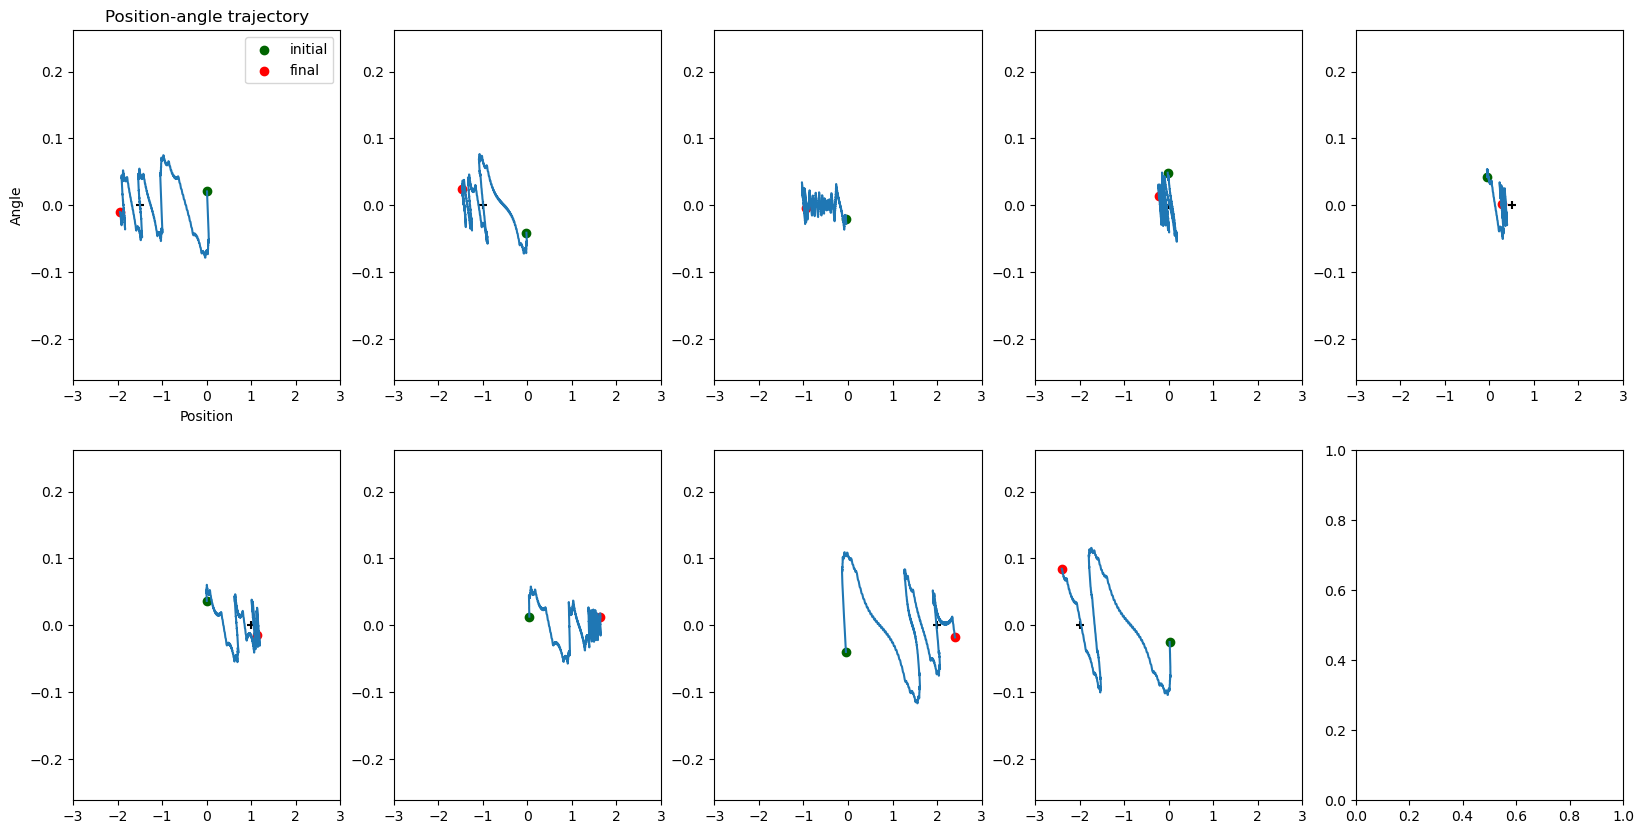

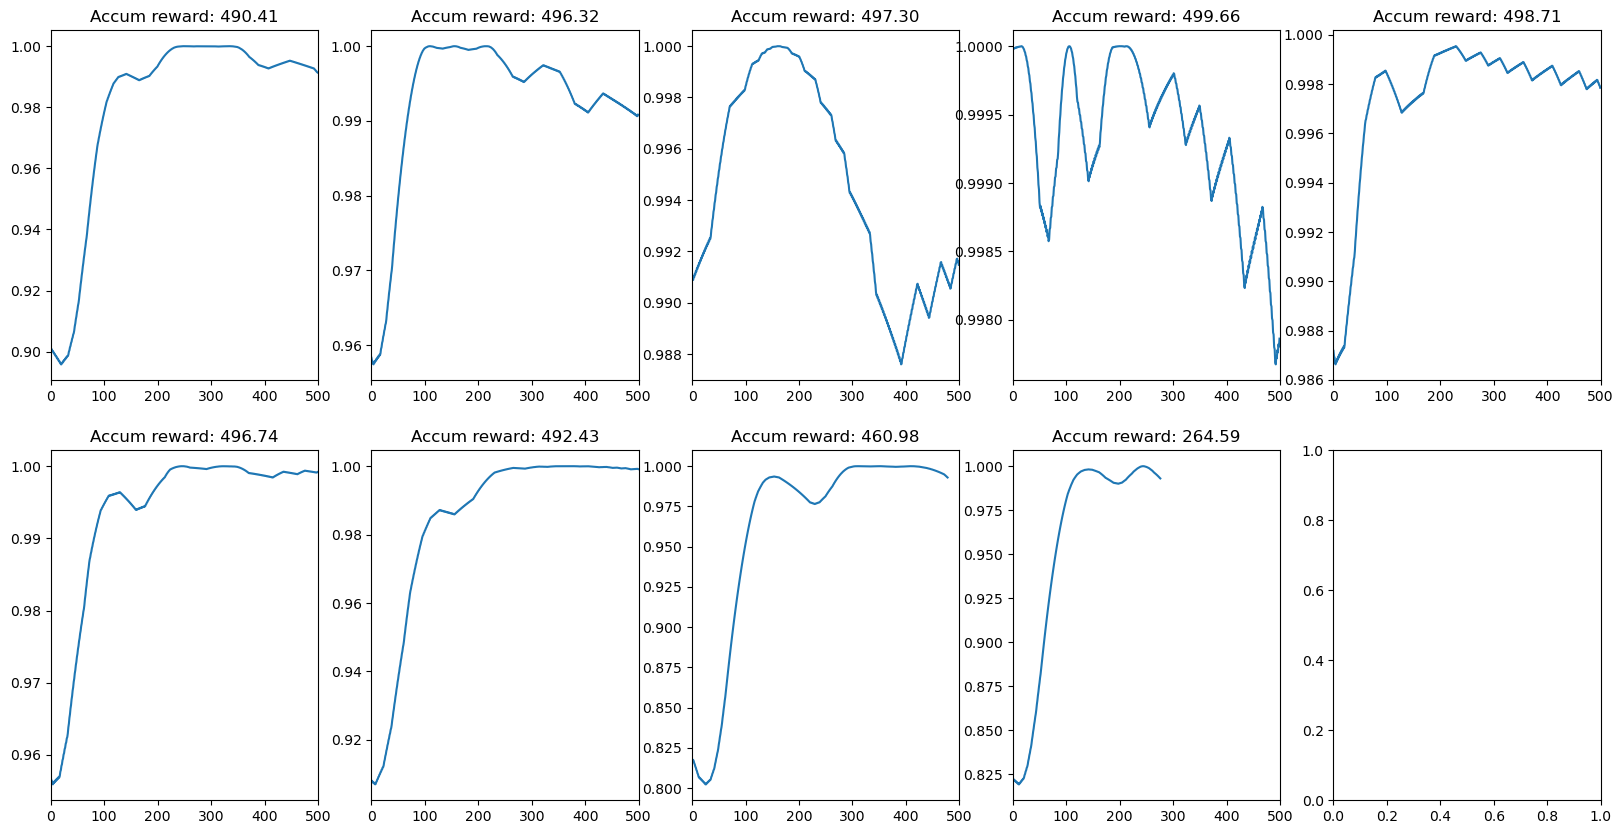

In [22]:
model = A2C.load('./logs/custom-cartpole-desire-1/best_model.zip')
final_eval = evaluate_policy(model,eval_env,n_eval_episodes = EVAL_EPISODES,deterministic = True)
print (f'Initial evaluation: {initial_eval}')
print (f'Best model evaluation: {final_eval}')

env = CartPoleEnvRandomTarget(render_mode='human',reward_function = 'custom',target_desire_factor=1,is_eval = True)
evaluate_trained_model(env,model)

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Comentari:</strong>
<br><br>
</div>

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
    <strong>Exercici 2.2 (1.25 punts):</strong> Fixant ara target_desire_factor = 1, proposa 2 modificacions de la funció de recompensa únicament de la component que té a veure amb el target i comenta els resultats obtinguts. Utilitza la mateixa estructura que fins ara (callback, model, avaluació inicial...).
</div>


In [23]:
env = CartPoleEnvRandomTarget(render_mode=None,reward_function = 'custom',target_desire_factor=1)
eval_env = CartPoleEnvRandomTarget(render_mode=None,reward_function = 'custom',target_desire_factor=0,is_eval = True)

#TODO: Repetir el mateix que en els exercicis anteriors. Callback, model, avaluació inicial, càrrega del millor model i entrenament.
#Al final, analitzar els resultats.
#Repetir per a les dues noves funcions d'error.

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Comentari:</strong>
<br><br>
</div>

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
    <strong>Exercici 2.3 (0.5 punts):</strong> A nivell teòric i suposant un temps d'entrenament més llarg amb uns hiperparàmetres més òptims, podríem arribar a esperar mai d'un agent amb una alpha = 1 (només es fixa en estar a prop del target) que aprengui a mantenir el pal en equilibri?
    Sabries trobar una equivalència amb el cas sense el target?
</div>


<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Comentari:</strong>
<br><br>
    Podem pensar el cas sense el target com a cas particular del cas amb target. A la versió original, podem suposar un target que està a tota la zona de moviment o bé un target que es mou amb el carro.
En aquest cas, només recompensant l'agent que estigui a prop del target (sempre està a distància 0) ja aprèn a mantenir el pal estable. Al final, com més temps mantingui el pal estable més temps estarà l'agent rebent les recompenses per estar a prop del target.
<br><br>
Pel cas on si existeix realment un target, podem esperar el mateix. No cal introduir cap funció de recompensa en base a l'angle més que per accelerar la convergència o facilitar l'entrenament. Només recompensant estar a prop del target, l'agent hauria d'intentar estar el màxim de temps possible amb el pal estable per poder aconseguir la màxima recompensa possible.
</div>

# 3. Increment de l'espai d'accions (1.5 pts)

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
    <strong>Exercici 3.1 (0.5 punts):</strong> Modifica el codi de tal manera que ara existeixin 6 accions en comptes de 2:
    <ul>
    <li>Accions 6,5,4, fer un 100%, 66% i 33% de força positiva respectivament</li>
    <li>Accions 1,2,3, fer un 100%, 66% i 33% de força negativa respectivament</li>
    </ul>

<strong>NOTA: A partir d'ara i fins al final de la pràctica es farà servir la recompensa custom que ja venia implementada amb target_desire_factor = 1</strong>
</div>


In [24]:
"""
Classic cart-pole system implemented by Rich Sutton et al.
Copied from http://incompleteideas.net/sutton/book/code/pole.c
permalink: https://perma.cc/C9ZM-652R
"""

import math
from typing import Optional, Union

import numpy as np

import gymnasium as gym
from gymnasium import spaces
from gymnasium.envs.classic_control import utils
from gymnasium.error import DependencyNotInstalled



class CartPoleEnvRandomTarget(gym.Env[np.ndarray, Union[int, np.ndarray]]):
    """
    ## Description

    This environment corresponds to a modification of the version of the cart-pole problem described by Barto, Sutton, and Anderson in
    ["Neuronlike Adaptive Elements That Can Solve Difficult Learning Control Problem"](https://ieeexplore.ieee.org/document/6313077).
    A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track.
    The pendulum is placed upright on the cart and the goal is to balance the pole by applying forces
     in the left and right direction on the cart.
     The modification consists on a target appearing into scene. The cart must be as close to the target as posible

    For more details about original cartpole look for source code in gymnasium.
    """


    metadata = {
        "render_modes": ["human", "rgb_array"],
        "render_fps": 50,
    }

    def __init__(
        self,
        target_desire_factor: float = 0.5,
        reward_function: str = "default",
        is_eval=False,
        increased_actions=False,
        render_mode: Optional[str] = None,
    ):

        self.gravity = 9.8
        self.masscart = 1.0
        self.masspole = 0.1
        self.total_mass = self.masspole + self.masscart
        self.length = 0.5  # actually half the pole's length
        self.polemass_length = self.masspole * self.length
        self.force_mag = 10.0
        self.tau = 0.02  # seconds between state updates

        self.max_steps = 500
        self.steps = 0

        # Angle at which to fail the episode
        self.theta_threshold_radians = 12 * 2 * math.pi / 360
        self.x_threshold = 2.4
        self.target_threshold = 2

        high = np.array(
            [
                self.x_threshold * 2,
                np.inf,
                self.theta_threshold_radians * 2,
                np.inf,
                self.target_threshold * 2,
            ],
            dtype=np.float32,
        )
        self.increased_actions = increased_actions
        if self.increased_actions:
            #TODO 3.1: Ampliar l'espai d'observacions
            self.action_space = spaces.Discrete(6)
        else:
            self.action_space = spaces.Discrete(2)
        self.observation_space = spaces.Box(-high, high, dtype=np.float32)

        self.render_mode = render_mode

        self.screen_width = 600
        self.screen_height = 400
        self.screen = None
        self.clock = None
        self.isopen = True
        self.state: np.ndarray | None = None

        self.steps_beyond_terminated = None

        #TODO 1.3: Tenir en compte si l'entorn és d'avaluació
        self.is_eval = is_eval
        self.eval_counter = 0
        self.eval_tests = [
            -self.target_threshold,
            -3 * self.target_threshold / 4,
            -2 * self.target_threshold / 4,
            -1 * self.target_threshold / 4,
            0,
            1 * self.target_threshold / 4,
            2 * self.target_threshold / 4,
            3 * self.target_threshold / 4,
            self.target_threshold,
        ]
        self.target_position = self.generate_random_target_position()

        self.target_desire_factor = min(
            max(target_desire_factor, 0), 1
        )  # between 0 and 1
        if reward_function in ["default", "custom"]:
            self.reward_function = reward_function
        else:
            raise AttributeError("reward function must be either default or custom")

    def generate_random_target_position(
        self,
    ):
        if self.is_eval:
            #TODO 1.3:Tingueu en compte si l'entorn és d'avaluació per situar el target en unes posicions concretes.
            target_position = self.eval_tests[self.eval_counter % len(self.eval_tests)]
            self.eval_counter += 1
            return target_position
        else:
            return np.random.uniform(-self.x_threshold, self.x_threshold)

    def custom_reward(self, target_position, current_position, angle, terminated):
        if self.reward_function == "default":
            #Reward default del cartpole
            return 1 if not terminated else 0
        else:
            angle_reward = (
                -abs(angle) / (2.0 * self.x_threshold) / self.theta_threshold_radians
            )
            target_reward = -(abs(target_position - current_position) ** 2) / (
                (2 * self.x_threshold) ** 2
            )
            return (
                1
                + self.target_desire_factor * target_reward
                + (1 - self.target_desire_factor) * angle_reward
            )
        #TODO 2.2: Implementar 2 funcions de reward extra

    def step(self, action):
        assert self.action_space.contains(
            action
        ), f"{action!r} ({type(action)}) invalid"
        assert self.state is not None, "Call reset before using step method."
        x, x_dot, theta, theta_dot, _ = self.state
        if self.increased_actions:
            force_factor = action - 2
            force = (
                force_factor / 3 * self.force_mag
                if force_factor > 0
                else (force_factor - 1) / 3 * self.force_mag
            )
        else:
            force = self.force_mag if action == 1 else -self.force_mag
        costheta = np.cos(theta)
        sintheta = np.sin(theta)

        # For the interested reader:
        # https://coneural.org/florian/papers/05_cart_pole.pdf
        temp = (
            force + self.polemass_length * np.square(theta_dot) * sintheta
        ) / self.total_mass
        thetaacc = (self.gravity * sintheta - costheta * temp) / (
            self.length
            * (4.0 / 3.0 - self.masspole * np.square(costheta) / self.total_mass)
        )
        xacc = temp - self.polemass_length * thetaacc * costheta / self.total_mass

        x = x + self.tau * x_dot
        x_dot = x_dot + self.tau * xacc
        theta = theta + self.tau * theta_dot
        theta_dot = theta_dot + self.tau * thetaacc

        self.state = np.array(
            (x, x_dot, theta, theta_dot, self.target_position), dtype=np.float64
        ) #Aquest estat es diferent respecte al del cartpole original

        terminated = bool(
            x < -self.x_threshold
            or x > self.x_threshold
            or theta < -self.theta_threshold_radians
            or theta > self.theta_threshold_radians
        )

        reward = self.custom_reward(self.target_position, x, theta, terminated)

        if self.render_mode == "human":
            self.render()

        # truncation=False as the time limit is handled by the `TimeLimit` wrapper added during `make`
        self.steps += 1
        if self.steps >= self.max_steps:
            truncated = True
        else:
            truncated = False
        return np.array(self.state, dtype=np.float32), reward, terminated, truncated, {}

    def reset(
        self,
        *,
        seed: Optional[int] = None,
        options: Optional[dict] = None,
    ):

        super().reset(seed=seed)
        self.steps = 0
        # Note that if you use custom reset bounds, it may lead to out-of-bound
        # state/observations.
        low, high = utils.maybe_parse_reset_bounds(
            options, -0.05, 0.05  # default low
        )  # default high

        self.state = self.np_random.uniform(low=low, high=high, size=(4,)).tolist()
        self.steps_beyond_terminated = None

        #Generar posició aleatòria del target i guardar en l'estat
        self.target_position = self.generate_random_target_position()
        self.state.append(self.target_position)

        self.state = np.array(self.state)
        if self.render_mode == "human":
            self.render()
        return np.array(self.state, dtype=np.float32), {}

    def render(self):
        if self.render_mode is None:
            assert self.spec is not None
            gym.logger.warn(
                "You are calling render method without specifying any render mode. "
                "You can specify the render_mode at initialization, "
                f'e.g. gym.make("{self.spec.id}", render_mode="rgb_array")'
            )
            return

        try:
            import pygame
            from pygame import gfxdraw
        except ImportError as e:
            raise DependencyNotInstalled(
                'pygame is not installed, run `pip install "gymnasium[classic-control]"`'
            ) from e

        if self.screen is None:
            pygame.init()
            if self.render_mode == "human":
                pygame.display.init()
                self.screen = pygame.display.set_mode(
                    (self.screen_width, self.screen_height)
                )
            else:  # mode == "rgb_array"
                self.screen = pygame.Surface((self.screen_width, self.screen_height))
        if self.clock is None:
            self.clock = pygame.time.Clock()

        world_width = self.x_threshold * 2
        scale = self.screen_width / world_width
        polewidth = 10.0
        polelen = scale * (2 * self.length)
        cartwidth = 50.0
        cartheight = 30.0
        targetwidth = 10
        targetheight = 10

        if self.state is None:
            return None

        x = self.state

        self.surf = pygame.Surface((self.screen_width, self.screen_height))
        self.surf.fill((255, 255, 255))

        l, r, t, b = -cartwidth / 2, cartwidth / 2, cartheight / 2, -cartheight / 2
        axleoffset = cartheight / 4.0
        cartx = x[0] * scale + self.screen_width / 2.0  # MIDDLE OF CART
        carty = 100  # TOP OF CART
        cart_coords = [(l, b), (l, t), (r, t), (r, b)]
        cart_coords = [(c[0] + cartx, c[1] + carty) for c in cart_coords]
        gfxdraw.aapolygon(self.surf, cart_coords, (0, 0, 0))
        gfxdraw.filled_polygon(self.surf, cart_coords, (0, 0, 0))

        l, r, t, b = (
            -polewidth / 2,
            polewidth / 2,
            polelen - polewidth / 2,
            -polewidth / 2,
        )

        pole_coords = []
        for coord in [(l, b), (l, t), (r, t), (r, b)]:
            coord = pygame.math.Vector2(coord).rotate_rad(-x[2])
            coord = (coord[0] + cartx, coord[1] + carty + axleoffset)
            pole_coords.append(coord)
        gfxdraw.aapolygon(self.surf, pole_coords, (202, 152, 101))
        gfxdraw.filled_polygon(self.surf, pole_coords, (202, 152, 101))

        gfxdraw.aacircle(
            self.surf,
            int(cartx),
            int(carty + axleoffset),
            int(polewidth / 2),
            (129, 132, 203),
        )
        gfxdraw.filled_circle(
            self.surf,
            int(cartx),
            int(carty + axleoffset),
            int(polewidth / 2),
            (129, 132, 203),
        )

        l, r, t, b = (
            -targetwidth / 2,
            targetwidth / 2,
            targetheight / 2,
            -targetheight / 2,
        )
        axleoffset = targetheight / 4.0
        targetx = x[-1] * scale + self.screen_width / 2.0  # MIDDLE OF target
        targety = 90  # TOP OF target
        target_coords = [(l, b), (l, t), (r, t), (r, b)]
        target_coords = [(c[0] + targetx, c[1] + targety) for c in target_coords]
        gfxdraw.aapolygon(self.surf, target_coords, (10, 255, 10))
        gfxdraw.filled_polygon(self.surf, target_coords, (10, 255, 10))

        gfxdraw.hline(self.surf, 0, self.screen_width, carty, (0, 0, 0))

        self.surf = pygame.transform.flip(self.surf, False, True)
        self.screen.blit(self.surf, (0, 0))
        if self.render_mode == "human":
            pygame.event.pump()
            self.clock.tick(self.metadata["render_fps"])
            pygame.display.flip()

        elif self.render_mode == "rgb_array":
            return np.transpose(
                np.array(pygame.surfarray.pixels3d(self.screen)), axes=(1, 0, 2)
            )

    def close(self):
        if self.screen is not None:
            import pygame

            pygame.display.quit()
            pygame.quit()
            self.isopen = False

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
    <strong>Exercici 3.2 (1 punt):</strong> Executa un entrenament i analitza els resultats. Per què han anat millor/pitjor? És el que esperaves?
</div>


In [25]:
#implementar abans els TODO de l'entorn
env = CartPoleEnvRandomTarget(render_mode=None,reward_function = 'custom',increased_actions = True,target_desire_factor=1)
eval_env = CartPoleEnvRandomTarget(render_mode=None,reward_function = 'custom',increased_actions = True,target_desire_factor=1,is_eval = True)

#TODO: Repetir el mateix que en els exercicis anteriors. Callback, model, avaluació inicial, càrrega del millor model i entrenament.
#Al final, analitzar els resultats.
callback = EvalCallback(eval_env = eval_env,
                        eval_freq = EVAL_FREQ,
                        n_eval_episodes = EVAL_EPISODES,
                        deterministic = True,
                        best_model_save_path = './logs/custom-cartpole-desire-1-more-actions/')

model = A2C("MlpPolicy", env,tensorboard_log  = './logs/custom-cartpole-desire-1-more-actions/')

initial_eval = evaluate_policy(model,eval_env,n_eval_episodes = EVAL_EPISODES,deterministic = True)
model.learn(total_timesteps=STEPS,
            callback = callback,
            progress_bar = True)
model = A2C.load('./logs/custom-cartpole-desire-1-more-actions/best_model.zip')
final_eval = evaluate_policy(model,eval_env,n_eval_episodes = EVAL_EPISODES,deterministic = True)

Eval num_timesteps=2000, episode_reward=34.97 +/- 25.69

Episode length: 36.78 +/- 24.95

New best mean reward!

Eval num_timesteps=4000, episode_reward=46.56 +/- 21.54

Episode length: 49.39 +/- 20.75

New best mean reward!

Eval num_timesteps=6000, episode_reward=40.18 +/- 21.81

Episode length: 42.50 +/- 20.95

Eval num_timesteps=8000, episode_reward=116.89 +/- 46.09

Episode length: 129.72 +/- 45.53

New best mean reward!

Eval num_timesteps=10000, episode_reward=342.50 +/- 118.21

Episode length: 380.67 +/- 132.38

New best mean reward!

Eval num_timesteps=12000, episode_reward=166.74 +/- 156.52

Episode length: 178.50 +/- 155.31

Eval num_timesteps=14000, episode_reward=130.36 +/- 135.16

Episode length: 139.72 +/- 135.30

Eval num_timesteps=16000, episode_reward=139.03 +/- 118.97

Episode length: 152.94 +/- 125.84

Eval num_timesteps=18000, episode_reward=314.21 +/- 196.04

Episode length: 330.67 +/- 203.01

Eval num_timesteps=20000, episode_reward=222.96 +/- 185.45

Episode length: 269.22 +/- 203.93

Initial evaluation: (22.94050872988171, 14.674119494749393)
Best model evaluation: (350.41792186101276, 132.54308956746317)


 11%|█████████▎                                                                          | 1/9 [00:13<01:49, 13.67s/it]

Epsisode finished in 332 timesteps. Total reward: 232.80687097394497


 22%|██████████████████▋                                                                 | 2/9 [00:29<01:44, 14.98s/it]

Epsisode finished in 385 timesteps. Total reward: 377.0033982546064


 33%|████████████████████████████                                                        | 3/9 [00:36<01:09, 11.50s/it]

Epsisode finished in 178 timesteps. Total reward: 173.32971494869992


 44%|█████████████████████████████████████▎                                              | 4/9 [00:57<01:15, 15.10s/it]

Epsisode finished in 500 timesteps. Total reward: 490.7083284643307


 56%|██████████████████████████████████████████████▋                                     | 5/9 [01:14<01:02, 15.59s/it]

Epsisode finished in 400 timesteps. Total reward: 383.24765563082065


 67%|████████████████████████████████████████████████████████                            | 6/9 [01:34<00:51, 17.29s/it]

Epsisode finished in 500 timesteps. Total reward: 473.2312855129643


 78%|█████████████████████████████████████████████████████████████████▎                  | 7/9 [01:55<00:36, 18.37s/it]

Epsisode finished in 500 timesteps. Total reward: 421.72661259451996


 89%|██████████████████████████████████████████████████████████████████████████▋         | 8/9 [02:15<00:19, 19.10s/it]

Epsisode finished in 500 timesteps. Total reward: 368.2031447357997


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [02:20<00:00, 15.66s/it]

Epsisode finished in 123 timesteps. Total reward: 109.24486612265738


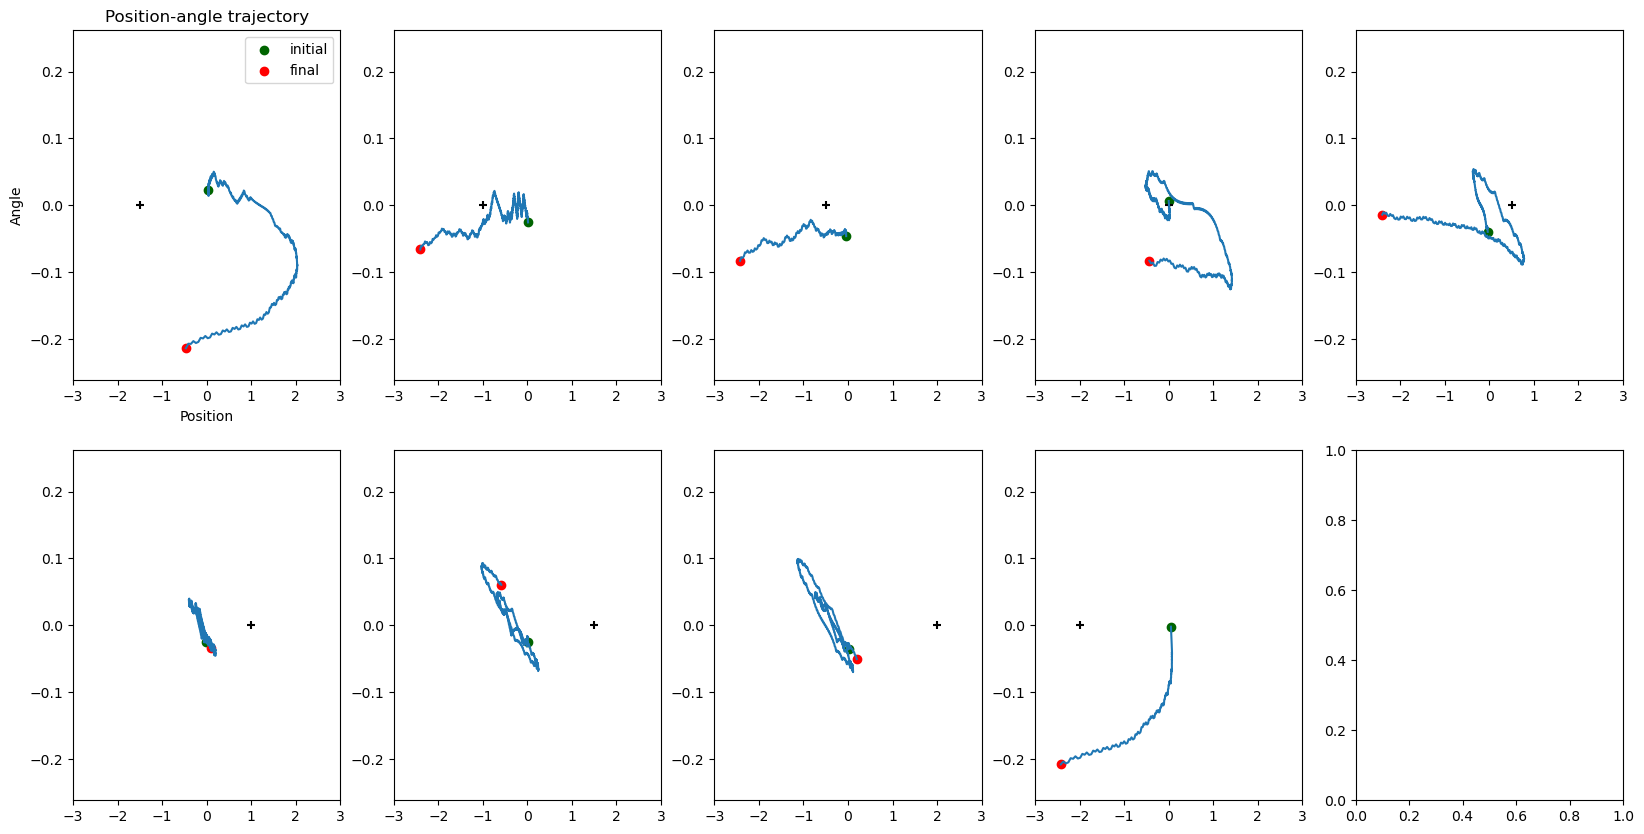

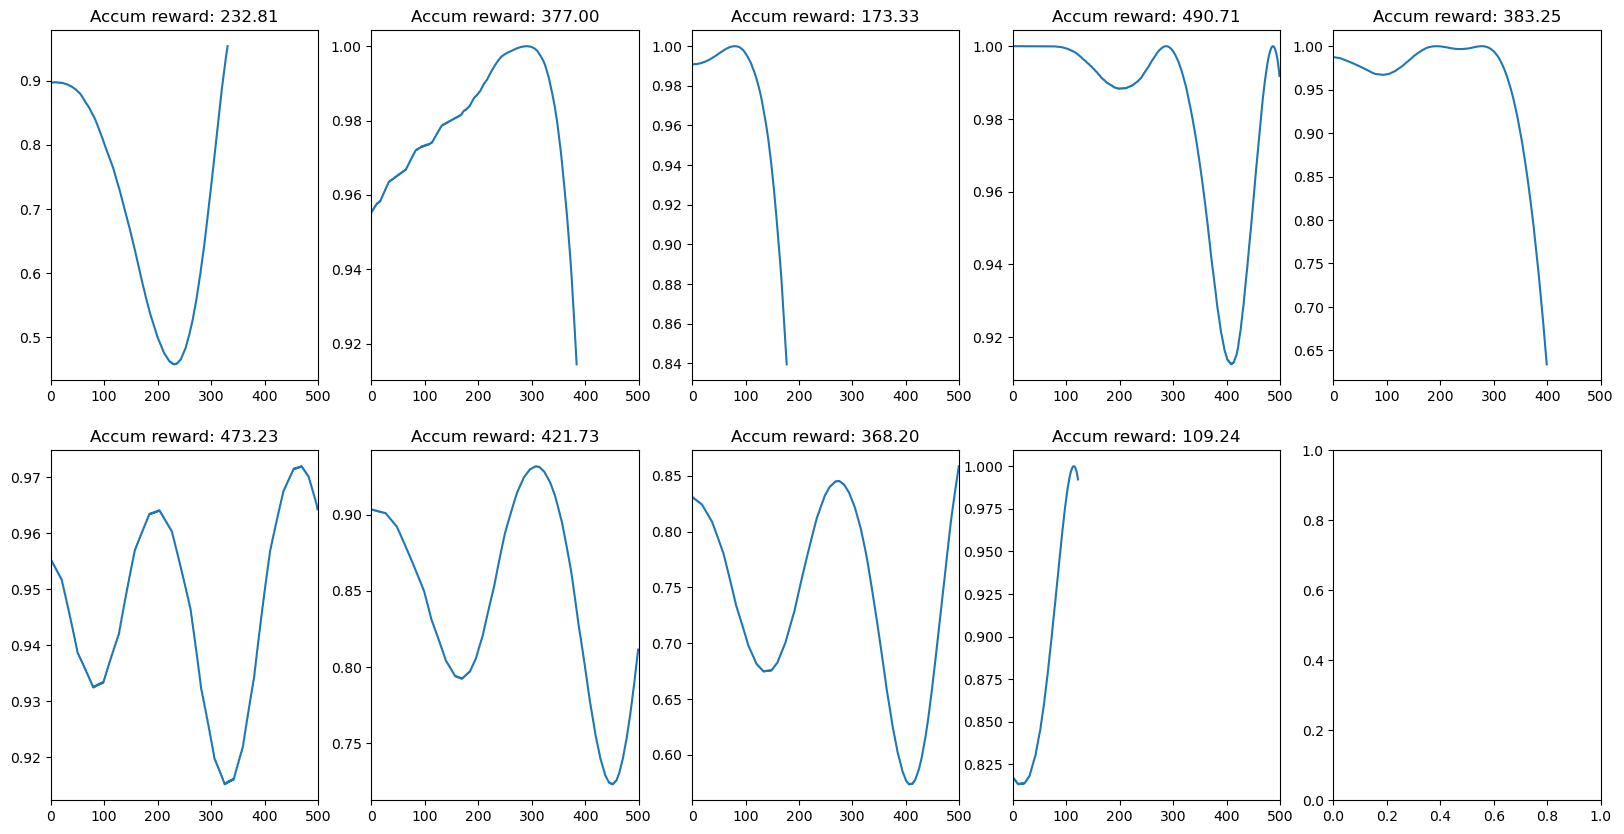

In [26]:
print (f'Initial evaluation: {initial_eval}')
print (f'Best model evaluation: {final_eval}')
env = CartPoleEnvRandomTarget(render_mode='human',reward_function = 'custom',increased_actions = True,target_desire_factor=1,is_eval = True)
evaluate_trained_model(env,model)

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Comentari:</strong>
<br><br>
</div>

# 4. Cerca d'hiperparàmetres (1.5 pts)

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
    <strong>Exercici 4.1 (1 punt):</strong> Utilitzant l'entorn amb desire_factor = 1 i amb les accions per defecte (no ampliades), busca els hiperparàmetres del model perquè aquest aprengui en menys de 10 mil passos. Us donem algunes pistes sobre el rang de valors que val la pena explorar:
    <ul>
    <li>gamma = (0.9,0.999). Es recomana cerca en escala logarítmica</li>
    <li>max_grad_norm = (0.3,5.0). Es recomana cerca en escala logarítmica</li>
    <li>n_steps = (8,32)</li>
    <li>learning_rate = (1e-5,1e-1). Es recomana cerca en escala logarítmica</li>
    <li>ent_coef = (1e-8,1e-3). Es recomana cerca en escala logarítmica</li>
    </ul>
    <strong>Important:</strong> La cerca d'hiperparàmetres s'ha de poder fer en 100 passos, és a dir, només caldria entrenar el model amb 100 combinacions diferents d'hiperparàmetres, res més.
    
Explica l'estratègia de cerca que s'ha seguit. Si s'utilitza una estratègia dummy tipus grid search, la puntuació màxima serà de 0.5/1 punts. Per aconseguir la màxima puntuació, podeu utilitzar frameworks com [optuna](https://optuna.org/#code_examples) per fer l'optimització d'hiperparàmetres.
</div>


In [27]:
STEPS = 10_000 #BAIXEM ELS STEPS A 10_000 per fer la cerca més ràpida
EVAL_EPISODES = 18
EVAL_FREQ = 2_000
N_TRIALS = 100  #Només farem 100 trials amb diferents combinacions d'hiperparàmetres

In [28]:
import optuna
from typing import Any
from typing import Dict

C:\Users\birth\Anaconda3\envs\RL_2024_PAC1\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [29]:
eval_env = CartPoleEnvRandomTarget(render_mode=None,reward_function = 'custom',increased_actions = False,target_desire_factor=1,is_eval = True)

#TODO: Cerca hiperparàmetres
def sample_a2c_params(trial: optuna.Trial) -> Dict[str, Any]:
    """Sampler for A2C hyperparameters."""
    gamma = 1.0 - trial.suggest_float("gamma", 0.001, 0.1, log=True)
    max_grad_norm = trial.suggest_float("max_grad_norm", 0.3, 5.0, log=True)
    n_steps = 2 ** trial.suggest_int("exponent_n_steps", 3, 5)
    learning_rate = trial.suggest_float("lr", 1e-5, 0.1, log=True)
    ent_coef = trial.suggest_float("ent_coef", 1e-8, 1e-3, log=True)

    # Display true values.
    trial.set_user_attr("gamma_", gamma)

    return {
        "gamma": gamma,
        'n_steps':n_steps,
        "learning_rate": learning_rate,
        "ent_coef": ent_coef,
        "max_grad_norm": max_grad_norm,
    }


class TrialEvalCallback(EvalCallback):
    """Callback used for evaluating and reporting a trial."""

    def __init__(
        self,
        eval_env: gym.Env,
        trial: optuna.Trial,
        n_eval_episodes: int = EVAL_EPISODES,
        eval_freq: int = EVAL_FREQ,
        deterministic: bool = True,
        verbose: int = 0,
    ):
        super().__init__(
            eval_env=eval_env,
            n_eval_episodes=n_eval_episodes,
            eval_freq=eval_freq,
            deterministic=deterministic,
            verbose=verbose,
            best_model_save_path = './logs/custom-cartpole-desire-1-more-actions-search/'
        )
        self.trial = trial
        self.eval_idx = 0
        self.is_pruned = False

    def _on_step(self) -> bool:
        if self.eval_freq > 0 and self.n_calls % self.eval_freq == 0:
            super()._on_step()
            self.eval_idx += 1
            self.trial.report(self.last_mean_reward, self.eval_idx)
            # Prune trial if need.
            if self.trial.should_prune():
                self.is_pruned = True
                return False
        return True


def objective(trial: optuna.Trial) -> float:
    kwargs = {'policy':"MlpPolicy", 'env':eval_env}
    # Sample hyperparameters.
    kwargs.update(sample_a2c_params(trial))
    # Create the RL model.
    model = A2C(**kwargs)

    # Create the callback that will periodically evaluate and report the performance.
    eval_callback = TrialEvalCallback(
        eval_env, trial, n_eval_episodes=EVAL_EPISODES, eval_freq=EVAL_FREQ, deterministic=True
    )

    nan_encountered = False
    try:
        model.learn(STEPS, callback=eval_callback)
    except AssertionError as e:
        # Sometimes, random hyperparams can generate NaN.
        print(e)
        nan_encountered = True
    finally:
        # Free memory.
        model.env.close()
        eval_env.close()

    # Tell the optimizer that the trial failed.
    if nan_encountered:
        return float("nan")

    if eval_callback.is_pruned:
        raise optuna.exceptions.TrialPruned()

    return eval_callback.last_mean_reward

In [35]:
study = optuna.create_study(direction="maximize")
try:
    study.optimize(objective, n_trials=N_TRIALS, timeout=600)
except KeyboardInterrupt:
    pass

print("Number of finished trials: ", len(study.trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

print("  User attrs:")
for key, value in trial.user_attrs.items():
    print("    {}: {}".format(key, value))

[I 2025-01-31 01:01:47,571] A new study created in memory with name: no-name-3eef1a29-22c1-4678-b479-e583ac0b24ac
[I 2025-01-31 01:02:26,166] Trial 0 finished with value: 8.799732794364294 and parameters: {'gamma': 0.0010585897364093018, 'max_grad_norm': 0.41676304567956746, 'exponent_n_steps': 3, 'lr': 0.013486891764106822, 'ent_coef': 0.0003257477995844553}. Best is trial 0 with value: 8.799732794364294.
[I 2025-01-31 01:03:27,532] Trial 1 finished with value: 465.19759578506154 and parameters: {'gamma': 0.006869130065966794, 'max_grad_norm': 0.3424452832496383, 'exponent_n_steps': 3, 'lr': 0.0019560336704064667, 'ent_coef': 0.00015099994770705934}. Best is trial 1 with value: 465.19759578506154.
[I 2025-01-31 01:04:28,951] Trial 2 finished with value: 124.5849213997523 and parameters: {'gamma': 0.0044712845172359735, 'max_grad_norm': 1.8902226868271226, 'exponent_n_steps': 3, 'lr': 0.0030653923691359728, 'ent_coef': 1.987854257968333e-06}. Best is trial 1 with value: 465.19759578506

Number of finished trials:  41
Best trial:
  Value:  482.1153260635005
  Params: 
    gamma: 0.0011075255640059282
    max_grad_norm: 0.3465814484938324
    exponent_n_steps: 5
    lr: 0.0022612847684910864
    ent_coef: 6.860582301392066e-05
  User attrs:
    gamma_: 0.998892474435994


<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Comentari:</strong>
<br><br>
</div>

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
    <strong>Exercici 4.2 (0.5 punts):</strong> Ara torna a entrenar un model durant 30_000 passos i analitza els resultats obtinguts.
</div>

In [31]:
print("Presiona Enter para continuar...")
input()
print("¡Continuamos!")

Presiona Enter para continuar...


¡Continuamos!


In [36]:
STEPS = 30_000
env = CartPoleEnvRandomTarget(render_mode=None,reward_function = 'custom',increased_actions = False,target_desire_factor=1)
eval_env = CartPoleEnvRandomTarget(render_mode=None,reward_function = 'custom',increased_actions = False,target_desire_factor=1,is_eval = True)

#TODO: Repetir el mateix que en els exercicis anteriors. Callback, model, avaluació inicial, càrrega del millor model i entrenament.
#Recordeu fer servir els millors hiperparametres trobats
#Al final, analitzar els resultats.
callback = EvalCallback(eval_env = eval_env,
                        eval_freq = EVAL_FREQ ,
                        n_eval_episodes = EVAL_EPISODES,
                        deterministic = True,
                        best_model_save_path = './logs/custom-cartpole-desire-1-hyperparam/')
model = A2C("MlpPolicy", env,
            gamma = 0.9989,max_grad_norm= 0.3466,n_steps= 2**5,learning_rate  = 0.0023,ent_coef=6.8606e-05,
            tensorboard_log  = './logs/custom-cartpole-desire-1-hyperparam/')

initial_eval = evaluate_policy(model,eval_env,n_eval_episodes = EVAL_EPISODES,deterministic = True)
model.learn(total_timesteps=STEPS,
            callback = callback,
            progress_bar = True)


Eval num_timesteps=2000, episode_reward=268.23 +/- 131.78

Episode length: 317.72 +/- 122.43

New best mean reward!

Eval num_timesteps=4000, episode_reward=430.33 +/- 70.12

Episode length: 500.00 +/- 0.00

New best mean reward!

Eval num_timesteps=6000, episode_reward=206.87 +/- 158.33

Episode length: 241.17 +/- 162.42

Eval num_timesteps=8000, episode_reward=475.07 +/- 21.51

Episode length: 500.00 +/- 0.00

New best mean reward!

Eval num_timesteps=10000, episode_reward=463.58 +/- 31.45

Episode length: 500.00 +/- 0.00

Eval num_timesteps=12000, episode_reward=435.07 +/- 57.67

Episode length: 500.00 +/- 0.00

Eval num_timesteps=14000, episode_reward=56.73 +/- 65.33

Episode length: 58.83 +/- 65.45

Eval num_timesteps=16000, episode_reward=138.77 +/- 130.50

Episode length: 149.56 +/- 129.11

Eval num_timesteps=18000, episode_reward=308.44 +/- 115.65

Episode length: 345.83 +/- 107.10

Eval num_timesteps=20000, episode_reward=286.60 +/- 147.71

Episode length: 344.72 +/- 124.86

Eval num_timesteps=22000, episode_reward=343.94 +/- 93.37

Episode length: 377.94 +/- 113.42

Eval num_timesteps=24000, episode_reward=252.56 +/- 132.60

Episode length: 262.78 +/- 134.48

Eval num_timesteps=26000, episode_reward=223.75 +/- 154.44

Episode length: 235.56 +/- 161.87

Eval num_timesteps=28000, episode_reward=245.01 +/- 22.74

Episode length: 287.83 +/- 28.40

Eval num_timesteps=30000, episode_reward=415.32 +/- 84.79

Episode length: 490.44 +/- 31.75

In [37]:
model = A2C.load('./logs/custom-cartpole-desire-1-hyperparam/best_model.zip')
final_eval = evaluate_policy(model,eval_env,n_eval_episodes = EVAL_EPISODES,deterministic = True)
print (f'Initial evaluation: {initial_eval}')
print (f'Best model evaluation: {final_eval}')

Initial evaluation: (8.568026304244995, 1.1590581197611516)
Best model evaluation: (475.5178575283951, 22.259090612367178)


 11%|█████████▎                                                                          | 1/9 [00:20<02:44, 20.60s/it]

Epsisode finished in 500 timesteps. Total reward: 463.9298986578625


 22%|██████████████████▋                                                                 | 2/9 [00:41<02:24, 20.60s/it]

Epsisode finished in 500 timesteps. Total reward: 487.0396030620916


 33%|████████████████████████████                                                        | 3/9 [01:01<02:03, 20.61s/it]

Epsisode finished in 500 timesteps. Total reward: 496.127732532553


 44%|█████████████████████████████████████▎                                              | 4/9 [01:22<01:43, 20.61s/it]

Epsisode finished in 500 timesteps. Total reward: 499.9616328495345


 56%|██████████████████████████████████████████████▋                                     | 5/9 [01:43<01:22, 20.60s/it]

Epsisode finished in 500 timesteps. Total reward: 496.8941661884078


 67%|████████████████████████████████████████████████████████                            | 6/9 [02:03<01:01, 20.60s/it]

Epsisode finished in 500 timesteps. Total reward: 486.17052384197274


 78%|█████████████████████████████████████████████████████████████████▎                  | 7/9 [02:24<00:41, 20.60s/it]

Epsisode finished in 500 timesteps. Total reward: 463.73940100428433


 89%|██████████████████████████████████████████████████████████████████████████▋         | 8/9 [02:44<00:20, 20.60s/it]

Epsisode finished in 500 timesteps. Total reward: 438.60215020483525


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [03:05<00:00, 20.60s/it]

Epsisode finished in 500 timesteps. Total reward: 439.02544264944623


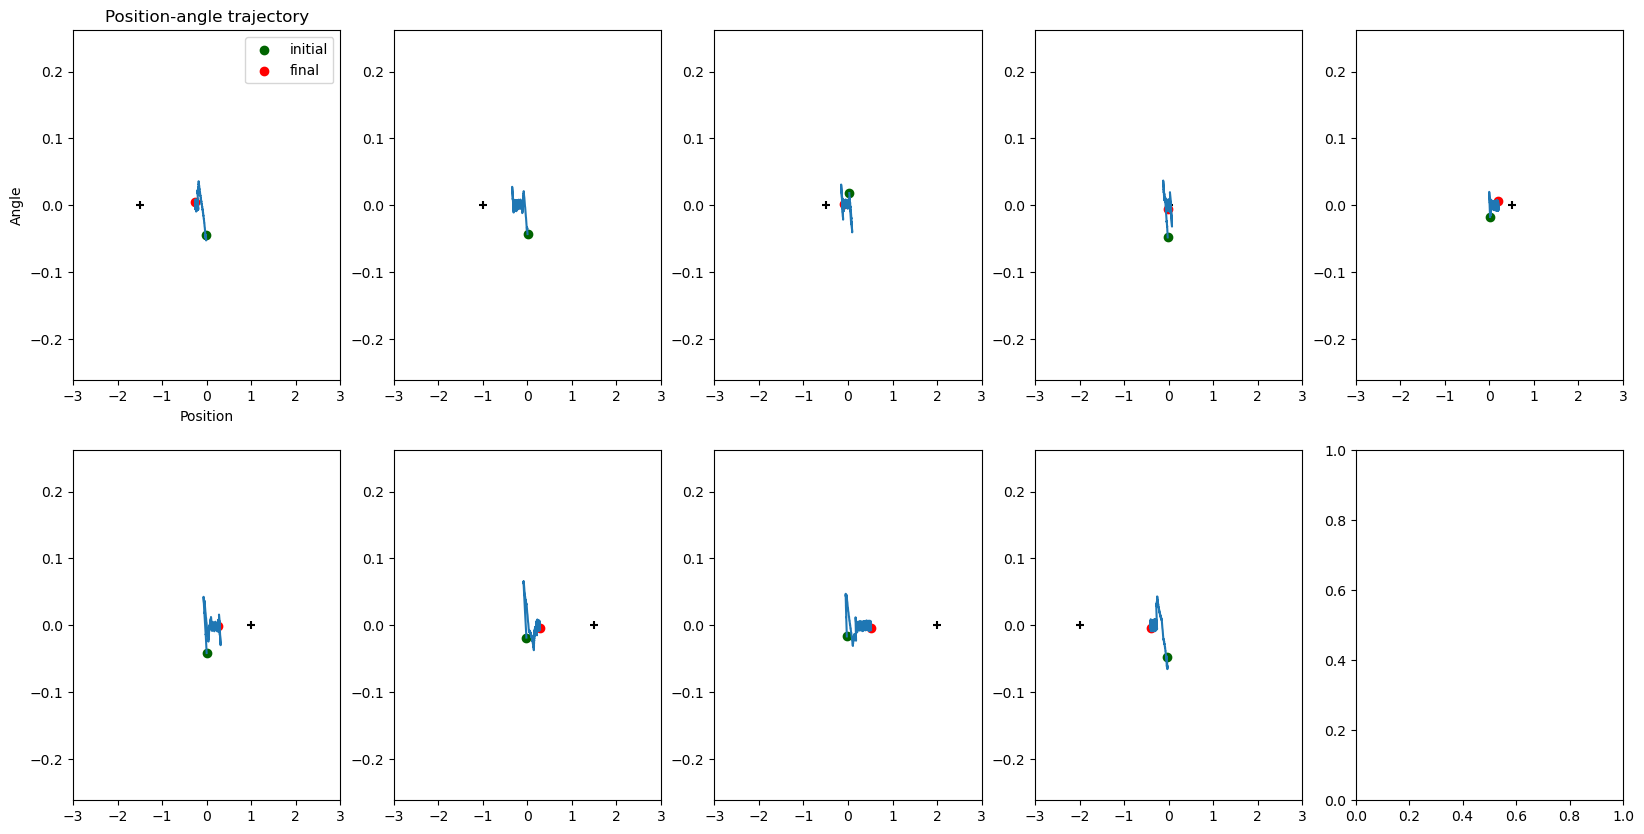

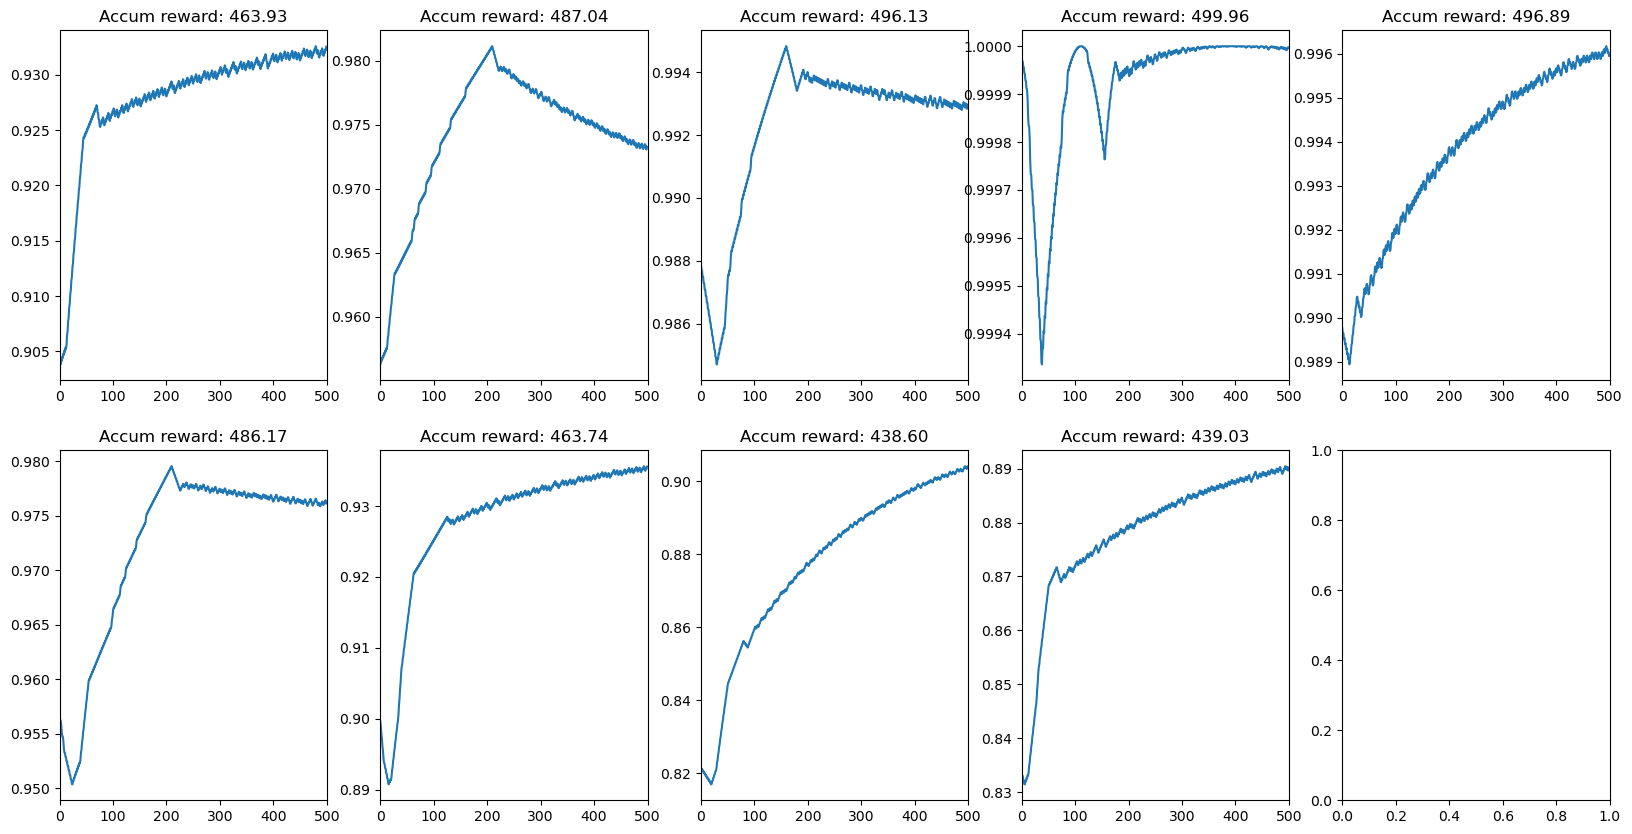

In [38]:
env = CartPoleEnvRandomTarget(render_mode='human',reward_function = 'custom',increased_actions = False,target_desire_factor=1,is_eval = True)
evaluate_trained_model(env,model)

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Comentari:</strong>
<br><br>
</div>